### Readme

###### Lending Club is a peer-to-peer lending company that connects borrowers with investors through an online platform. It serves people who need personal loans ranging from $1,000 to $40,000. Borrowers receive the full amount of their loan minus an origination fee that is paid to the company. Investors purchase notes secured by personal loans and pay Lending Club a service fee. Lending Club provides data on all loans originated through its platform during specified periods.
###### For the purposes of this project, data on loans granted through Lending Club from 2007 to 2011 were used. Each loan has information about whether it has finally been repaid (Fully Paid or Charged off in the loan_status column). Your task is to build a classification model that, based on this data, will predict with a certain accuracy whether a potential borrower will repay his debt under the loan. The data set includes a file with a description of all variables and the "FICO Score ranged.pdf" file, which describes in detail the meaning of one of the columns.
###### The individual stages of analysis required to complete the project and their scoring are presented below:
##### Data Processing – as an experienced Data Scientist, you probably know the individual steps that need to be performed at this stage, so we will not detail them here.
##### EDA, i.e. extensive data exploration - Describe the conclusions drawn from each graph, support your hypotheses with statistical tests such as t-test or Chi-square. Additionally, answer the following questions:
###### How does a FICO score relate to a borrower's likelihood of repaying a loan?
###### How does credit age relate to the probability of default and whether this risk is independent of or related to FICO score?
###### How does home mortgage status relate to the likelihood of default?
###### How is annual income related to the probability of default?
###### How is employment history related to the likelihood of default?
###### How is the size of the loan requested related to the probability of default?
##### Feature Engineering – create 20 new variables.
##### Modeling
###### Cluster the data (try several methods, at least 3) and check whether there are any borrower segments, use appropriate methods to determine the optimal number of clusters.
###### Train 5 different models, using a different algorithm for each, and then compare their performance, using the AUROC score as the model quality metric.
###### Check the operation of previously used methods on compressed data using PCA, compare the results (AUROC score) with the models trained in the previous section.
###### Build the final model whose AUROC score will be >= 80%, remember to select important variables, cross-validate and tune model parameters, also think about balancing classes.

### Project

##### Data preparing and cleaning

In [1]:
# Import csv, load the data and show data shape.
import pandas as pd
import warnings
warnings.filterwarnings("ignore")

data = pd.read_csv('Loan_data.csv', low_memory=False)
df = pd.DataFrame(data)
# df.shape

In [2]:
# Show empty values in %.
missing = round(100*(df.isnull().sum()/len(df.id)), 2)
pd.set_option('display.max_columns', None)
missing.loc[missing > 0]

member_id                100.00
emp_title                  6.18
emp_length                 2.62
annual_inc                 0.01
desc                      31.26
                          ...  
settlement_status         99.62
settlement_date           99.62
settlement_amount         99.62
settlement_percentage     99.62
settlement_term           99.62
Length: 111, dtype: float64

In [3]:
# The number of columns that have more than 50% empty values.
columns_with_missing_values = list(missing[missing >= 50].index)

# Removing columns that do not meet the condition > 50% non-empty values and show data shape.
df = df.drop(columns_with_missing_values,axis=1)

# Showing the share of non-empty values in the updated set.
missing = round(100*(df.isnull().sum()/len(df.id)), 2)
missing[missing != 0]

emp_title                      6.18
emp_length                     2.62
annual_inc                     0.01
desc                          31.26
title                          0.03
delinq_2yrs                    0.07
earliest_cr_line               0.07
inq_last_6mths                 0.07
open_acc                       0.07
pub_rec                        0.07
revol_util                     0.21
total_acc                      0.07
last_pymnt_d                   0.20
last_credit_pull_d             0.01
collections_12_mths_ex_med     0.34
acc_now_delinq                 0.07
chargeoff_within_12_mths       0.34
delinq_amnt                    0.07
pub_rec_bankruptcies           3.21
tax_liens                      0.25
dtype: float64

In [4]:
# Removing columns that are not important from the point of view of statistics and modeling.
df = df.drop(
    [
        'desc', 
        'id', 
        'emp_title', 
        'url', 
        'title',
    ], axis=1)

# Create a function showing unique values in the set.
def data_unique(dataset):
    for column in dataset.columns:
        unique_values = dataset[column].unique()
        print(f"'{column}': \n{unique_values}")
        print()

data_unique(df)

'loan_amnt': 
[ 5000.  2500.  2400. 10000.  3000.  7000.  5600.  5375.  6500. 12000.
  9000.  1000.  3600.  6000.  9200. 20250. 21000. 15000.  4000.  8500.
  4375. 31825. 12400. 10800. 12500.  9600.  4400. 14000. 11000. 25600.
 16000.  7100. 13000. 17500. 17675.  8000.  3500. 16425.  8200. 20975.
  6400. 14400.  7250. 18000. 35000. 11800.  4500. 10500. 15300. 20000.
  6200.  7200.  9500. 18825. 24000.  2100.  5500. 26800. 25000. 19750.
 13650. 28000. 10625.  8850.  6375. 11100.  4200.  8875. 13500. 21600.
  8450. 13475. 22000.  7325.  7750. 13350. 22475.  8400. 13250.  7350.
 11500. 29500.  2000. 11625. 15075.  5300.  8650.  7400. 24250. 26000.
  1500. 19600.  4225. 16500. 15600. 14125. 13200. 12300.  1400.  3200.
 11875.  1800. 23200.  4800.  7300. 10400.  6600. 30000.  4475.  6300.
  8250.  9875. 21500.  7800.  9750. 15550. 17000.  7500.  5800.  8050.
  5400.  4125.  9800. 15700.  9900.  6250. 10200. 23000. 25975. 21250.
 33425.  8125. 18800. 19200. 12875.  2625. 11300.  4100. 18225.

In [5]:
# Changing key values regarding the loan status - setting two values: Fully Paid and Chardeg Off.
df['loan_status'] = df['loan_status'].replace({'Does not meet the credit policy. Status:Fully Paid': 'Fully Paid',
                                               'Does not meet the credit policy. Status:Charged Off': 'Charged Off'})

# Removing blank rows from columns required for further exploration and modeling.
df = df.dropna(subset=['loan_status'])
df = df.dropna(subset=['earliest_cr_line'])
df = df.dropna(subset=['last_credit_pull_d'])

In [6]:
# Removing of further columns that do not affect statistics and modeling.
df = df.drop([
    'pymnt_plan',
    'initial_list_status',
    'out_prncp',
    'out_prncp_inv',
    'collections_12_mths_ex_med',
    'policy_code',
    'application_type',
    'chargeoff_within_12_mths',
    'hardship_flag',
    'disbursement_method',
    'funded_amnt', 
    'funded_amnt_inv',
    'recoveries',
    'fico_range_high'
], axis=1)

df.shape
df.head()

loan_amnt        term int_rate  installment grade sub_grade emp_length  \
0     5000.0   36 months   10.65%       162.87     B        B2  10+ years   
1     2500.0   60 months   15.27%        59.83     C        C4   < 1 year   
2     2400.0   36 months   15.96%        84.33     C        C5  10+ years   
3    10000.0   36 months   13.49%       339.31     C        C1  10+ years   
4     3000.0   60 months   12.69%        67.79     B        B5     1 year   

  home_ownership  annual_inc verification_status   issue_d  loan_status  \
0           RENT     24000.0            Verified  Dec-2011   Fully Paid   
1           RENT     30000.0     Source Verified  Dec-2011  Charged Off   
2           RENT     12252.0        Not Verified  Dec-2011   Fully Paid   
3           RENT     49200.0     Source Verified  Dec-2011   Fully Paid   
4           RENT     80000.0     Source Verified  Dec-2011   Fully Paid   

          purpose zip_code addr_state    dti  delinq_2yrs earliest_cr_line  \
0     credit_card    860xx         AZ  27.65          0.0         Jan-1985   
1             car    309xx         GA   1.00          0.0         Apr-1999   
2  small_business    606xx         IL   8.72          0.0         Nov-2001   
3           other    917xx         CA  20.00          0.0         Feb-1996   
4           other    972xx         OR  17.94          0.0         Jan-1996   

   fico_range_low  inq_last_6mths  open_acc  pub_rec  revol_bal revol_util  \
0           735.0             1.0       3.0      0.0    13648.0      83.7%   
1           740.0             5.0       3.0      0.0     1687.0       9.4%   
2           735.0             2.0       2.0      0.0     2956.0      98.5%   
3           690.0             1.0      10.0      0.0     5598.0        21%   
4           695.0             0.0      15.0      0.0    27783.0      53.9%   

   total_acc   total_pymnt  total_pymnt_inv  total_rec_prncp  total_rec_int  \
0        9.0   5863.155187          5833.84          5000.00         863.16   
1        4.0   1014.530000          1014.53           456.46         435.17   
2       10.0   3005.666844          3005.67          2400.00         605.67   
3       37.0  12231.890000         12231.89         10000.00        2214.92   
4       38.0   4066.908161          4066.91          3000.00        1066.91   

   total_rec_late_fee  collection_recovery_fee last_pymnt_d  last_pymnt_amnt  \
0                0.00                     0.00     Jan-2015           171.62   
1                0.00                     1.11     Apr-2013           119.66   
2                0.00                     0.00     Jun-2014           649.91   
3               16.97                     0.00     Jan-2015           357.48   
4                0.00                     0.00     Jan-2017            67.30   

  last_credit_pull_d  last_fico_range_high  last_fico_range_low  \
0           Aug-2018                 739.0                735.0   
1           Oct-2016                 499.0                  0.0   
2           Jun-2017                 739.0                735.0   
3           Apr-2016                 604.0                600.0   
4           Apr-2018                 684.0                680.0   

   acc_now_delinq  delinq_amnt  pub_rec_bankruptcies  tax_liens  \
0             0.0          0.0                   0.0        0.0   
1             0.0          0.0                   0.0        0.0   
2             0.0          0.0                   0.0        0.0   
3             0.0          0.0                   0.0        0.0   
4             0.0          0.0                   0.0        0.0   

  debt_settlement_flag  
0                    N  
1                    N  
2                    N  
3                    N  
4                    N

In [7]:
# Creating a column with the borrower's age, 
# replacing the % text values with numerical values in the 'int_rate' column 
# and removing columns that could introduce errors in further exploration and modeling.

from datetime import datetime
import re

df['earliest_cr_line'] = pd.to_datetime(df['earliest_cr_line'], format='%b-%Y', errors='coerce')
df['last_credit_pull_d'] = pd.to_datetime(df['last_credit_pull_d'], format='%b-%Y', errors='coerce')
df['last_credit_pull_d'].fillna(datetime.today(), inplace=True)
df['credit_years'] = (df['last_credit_pull_d'] - df['earliest_cr_line']).dt.days // 365
df['credit_years'] = df['credit_years'].fillna(df['credit_years'].mean)

def percent_to_float(percent):
    if isinstance(percent, str):
        return float(re.sub(r'%', '', percent)) / 100
    else:
        return percent / 100

df['int_rate'] = df['int_rate'].apply(percent_to_float)
df['revol_util'] = df['revol_util'].apply(percent_to_float)

df = df.drop(
    [
        'earliest_cr_line',
        'last_credit_pull_d',
        'issue_d',
        'last_pymnt_d',
        'last_fico_range_high',
        'last_fico_range_low'
    ], axis=1
)

# df.head()

In [8]:
# Replacing empty values in the set's columns with the most frequently occurring values - mode.

def replace_nan_with_mode(df):
    for col in df.columns:
        mode_val = df[col].mode()[0]
        df[col].fillna(mode_val, inplace=True)

replace_nan_with_mode(df)

data_unique(df)

'loan_amnt': 
[ 5000.  2500.  2400. 10000.  3000.  7000.  5600.  5375.  6500. 12000.
  9000.  1000.  3600.  6000.  9200. 20250. 21000. 15000.  4000.  8500.
  4375. 31825. 12400. 10800. 12500.  9600.  4400. 14000. 11000. 25600.
 16000.  7100. 13000. 17500. 17675.  8000.  3500. 16425.  8200. 20975.
  6400. 14400.  7250. 18000. 35000. 11800.  4500. 10500. 15300. 20000.
  6200.  7200.  9500. 18825. 24000.  2100.  5500. 26800. 25000. 19750.
 13650. 28000. 10625.  8850.  6375. 11100.  4200.  8875. 13500. 21600.
  8450. 13475. 22000.  7325.  7750. 13350. 22475.  8400. 13250.  7350.
 11500. 29500.  2000. 11625. 15075.  5300.  8650.  7400. 24250. 26000.
  1500. 19600.  4225. 16500. 15600. 14125. 13200. 12300.  1400.  3200.
 11875.  1800. 23200.  4800.  7300. 10400.  6600. 30000.  4475.  6300.
  8250.  9875. 21500.  7800.  9750. 15550. 17000.  7500.  5800.  8050.
  5400.  4125.  9800. 15700.  9900.  6250. 10200. 23000. 25975. 21250.
 33425.  8125. 18800. 19200. 12875.  2625. 11300.  4100. 18225.

In [9]:
# # If you want to look at the data in GUI report.

# import ydata_profiling as pp
# pp.ProfileReport(df)

#### EDA

How does a FICO score relate to a borrower's likelihood of repaying a loan?

The graph shows that as FICO increases, the probability of loan repayment increases.
At lower values this indicator is low.
The outliers suggest that there were cases where a borrower with a low FICO score defaulted on the loan.
This may be due to the fact that in this way a positive history of the borrower is built.



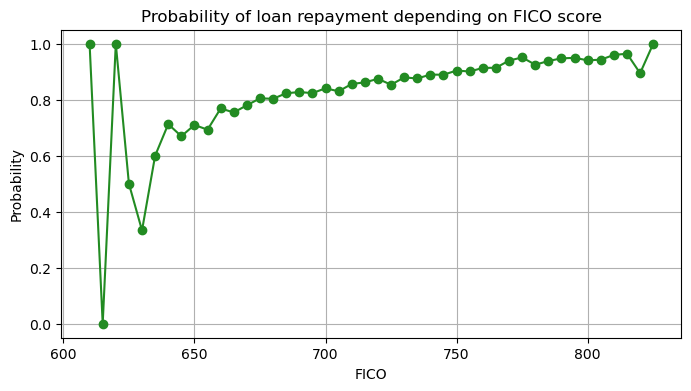

In [10]:
import matplotlib.pyplot as plt

prob = df.groupby('fico_range_low')['loan_status'].apply(lambda x: (x == 'Fully Paid').mean()).reset_index()

plt.figure(figsize=(8, 4))
plt.plot(prob['fico_range_low'], prob['loan_status'], marker='o', color='forestgreen')
plt.xlabel('FICO')
plt.ylabel('Probability')
plt.title('Probability of loan repayment depending on FICO score')
plt.grid(True)
plt.show

print('The graph shows that as FICO increases, the probability of loan repayment increases.\n'
      'At lower values this indicator is low.\n'
      'The outliers suggest that there were cases where a borrower with a low FICO score defaulted on the loan.\n'
      'This may be due to the fact that in this way a positive history of the borrower is built.\n')

In [11]:
# Test Chi.

from scipy.stats import chi2_contingency

# Contingency table.
contingency_table = pd.crosstab(data['loan_status'], data['fico_range_low'])

# Chi2 test.
chi2, p, dof, expected = chi2_contingency(contingency_table)

alpha = 0.05
print(60 * '#')
print("Chi-square statistic:", chi2)
print("p-value:", p)
print("Degrees of freedom:", dof)
print(60 * '#')
if p < alpha:
    print("We reject the null hypothesis - there is a significant relationship between loan_status and fico_range_low.")
else:
    print("There is insufficient evidence to reject the null hypothesis - no significant relationship between loan_status and fico_range_low.")
print(60 * '#')
print("Expected values:", expected)
print(60 * '#')

############################################################
Chi-square statistic: 8827.738168939075
p-value: 0.0
Degrees of freedom: 129
############################################################
We reject the null hypothesis - there is a significant relationship between loan_status and fico_range_low.
############################################################
Expected values: [[2.66603973e-01 1.33301987e-01 1.33301987e-01 2.66603973e-01
  7.99811920e-01 6.66509933e-01 1.35968026e+01 1.49298225e+01
  1.74625602e+01 1.69293523e+01 2.11150347e+02 2.42742918e+02
  2.47141883e+02 2.65804161e+02 2.96996826e+02 3.07927589e+02
  2.92731163e+02 2.93530974e+02 3.02195604e+02 2.62604914e+02
  2.36077818e+02 2.52074057e+02 2.59805572e+02 2.52074057e+02
  2.22614318e+02 2.20348184e+02 1.98619960e+02 1.75825320e+02
  1.72492771e+02 1.46632185e+02 1.31169155e+02 1.05575173e+02
  1.06508287e+02 8.71794992e+01 7.63820383e+01 5.41206066e+01
  5.62534383e+01 4.50560715e+01 3.41253086e+01 2.57272834

How does credit age relate to the probability of default and whether this risk is independent of or related to FICO score?

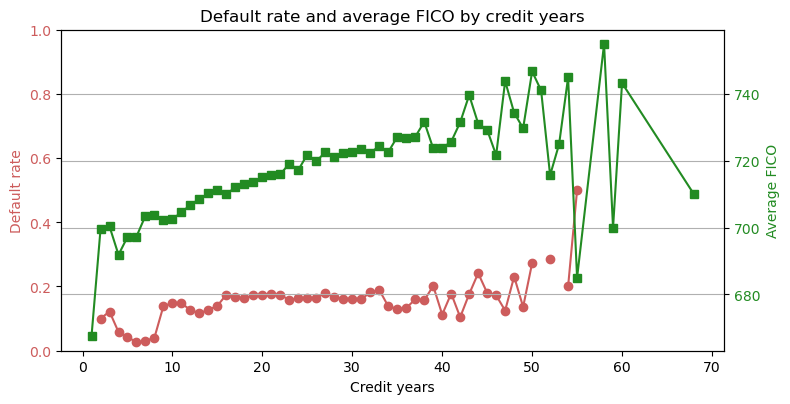

FICO minimum:  610.0
FICO maximum:  825.0
Correlation between FICO and default rate: -0.7665072009787173 

Loan default is proportional to credit age: the higher the age, the greater the probability that the loan will default.
Moreover, the FICO score has no impact on the above analysis, also taking into account age.
The FICO index ranges from 610.0 to 825.0 i.e. in the good and very good ranges for the borrower.


In [12]:
def_rate_cy = df[df['loan_status'] == 'Charged Off'].groupby('credit_years').size() / df.groupby('credit_years').size()

fig, ax1 = plt.subplots(figsize=(8, 4))
ax1.set_xlabel('Credit years')
ax1.set_ylabel('Default rate', color='indianred')
ax1.plot(def_rate_cy.index, def_rate_cy.values, marker='o', color='indianred')
ax1.tick_params(axis='y', labelcolor='indianred')
ax1.set_ylim(0, 1)

ax2 = ax1.twinx()  
ax2.set_ylabel('Average FICO', color='forestgreen')
ax2.plot(df.groupby('credit_years')['fico_range_low'].mean(), marker='s', color='forestgreen')
ax2.tick_params(axis='y', labelcolor='forestgreen')

fig.tight_layout()  
plt.title('Default rate and average FICO by credit years')
plt.grid(True)
plt.show()

default_rate_2 = df[df['loan_status'] == 'Charged Off'].groupby('fico_range_low').size() / df.groupby('fico_range_low').size()
correlation = df.groupby('fico_range_low')['credit_years'].mean().corr(default_rate_2)

print("FICO minimum: ", df['fico_range_low'].min())
print("FICO maximum: ", df['fico_range_low'].max())

print("Correlation between FICO and default rate:", correlation, '\n')
print('Loan default is proportional to credit age: the higher the age, the greater the probability that the loan will default.\n'
      'Moreover, the FICO score has no impact on the above analysis, also taking into account age.\n'
      'The FICO index ranges from', df['fico_range_low'].min(), 'to', df['fico_range_low'].max(), 'i.e. in the good and very good ranges for the borrower.')


How does home mortgage status relate to the likelihood of default?

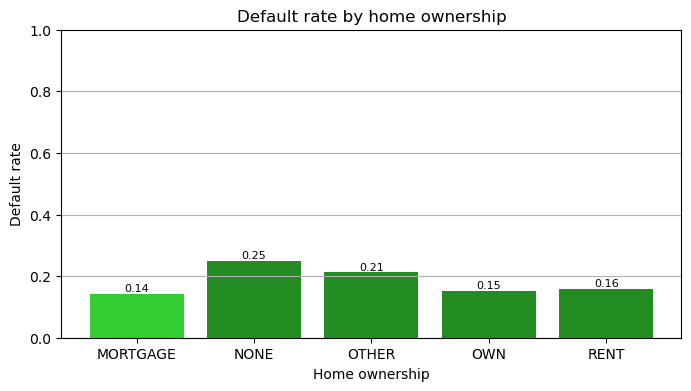

Having a mortgage loan has the best loan repayment rate, i.e. the lowest default rate.


In [13]:
def_rate_ho = df[df['loan_status'] == 'Charged Off'].groupby('home_ownership').size() / df.groupby('home_ownership').size()

plt.figure(figsize=(8, 4))
bars = plt.bar(def_rate_ho.index, def_rate_ho.values, color=[
    'limegreen', 'forestgreen', 'forestgreen', 'forestgreen', 'forestgreen'])
plt.xlabel('Home ownership')
plt.ylabel('Default rate')
plt.ylim(0, 1)
plt.title('Default rate by home ownership')

for i, value in enumerate(def_rate_ho.values):
    plt.text(i, value, f'{value:.2f}', ha='center', va='bottom', fontsize=8)

plt.grid(axis='y')
plt.show()

print('Having a mortgage loan has the best loan repayment rate, i.e. the lowest default rate.')

In [14]:
# Test Chi.

# Contingency table.
contingency_table = pd.crosstab(df['loan_status'], df['home_ownership'])

# Performing chi-squared test.
chi2, p, dof, expected = chi2_contingency(contingency_table)

alpha = 0.05
print(60 * '#')
print("Chi-square statistic:", chi2)
print("p-value:", p)
print("Degrees of freedom:", dof)
print(60 * '#')
if p < alpha:
    print("There is a significant relationship between home ownership and loan status.")
else:
    print("There is no significant relationship between home ownership and loan status.")
print(60 * '#')
print("Expected frequencies table:\n", expected)

############################################################
Chi-square statistic: 25.277701401417715
p-value: 4.423791587737841e-05
Degrees of freedom: 4
############################################################
There is a significant relationship between home ownership and loan status.
############################################################
Expected frequencies table:
 [[2.86563483e+03 6.04851422e-01 2.05649484e+01 4.91441781e+02
  3.04875359e+03]
 [1.60853652e+04 3.39514858e+00 1.15435052e+02 2.75855822e+03
  1.71132464e+04]]


How is annual income related to the probability of default?

max annual inc:  6000000.0


posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values


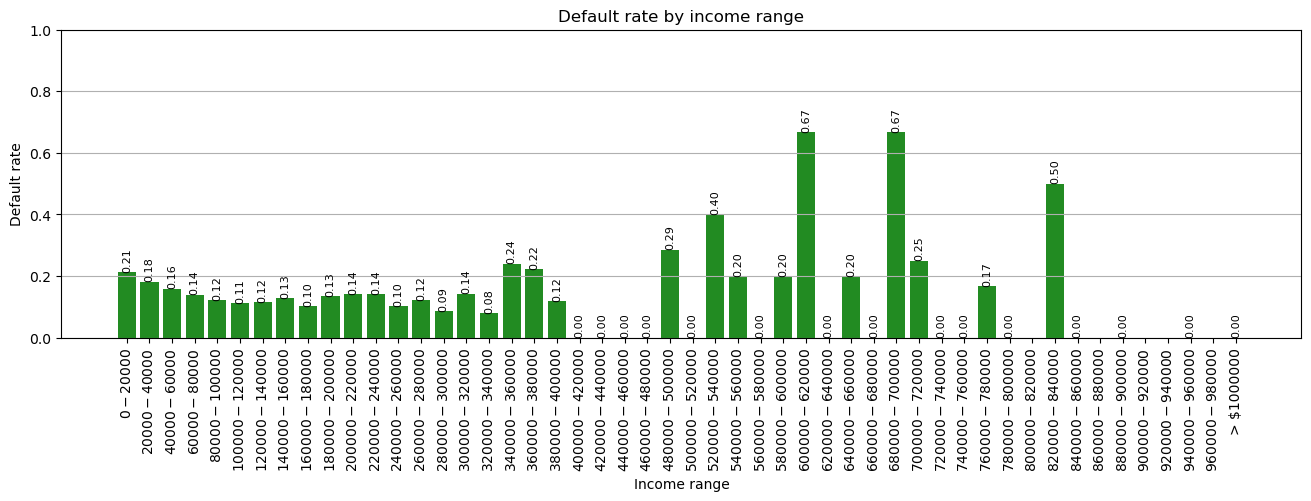

The probability of not repaying the loan decreases as the salary increases, ranging from $20k to $340k.
Interestingly, in the next ranges, where the salary increases significantly, the probability of loan repayment decreases quite significantly.
For salaries of $600k - $620k, $680k - $700k and $820k - $840k, the probability of loan default is greater than or equal to 50%.


In [15]:
print('max annual inc: ', df['annual_inc'].max())

max_income = 1000000
income_bins = list(range(0, max_income + 1, 20000))
income_labels = [f'${i} - ${i + 20000}' for i in range(0, max_income, 20000)]
income_labels[-1] = f'> ${max_income}'

df['income_range'] = pd.cut(df['annual_inc'], bins=income_bins, labels=income_labels)

def_rate_ir = df[df['loan_status'] == 'Charged Off'].groupby('income_range').size() / df.groupby('income_range').size()

fig, ax = plt.subplots(figsize=(16, 4))
ax.bar(def_rate_ir.index, def_rate_ir.values, color='forestgreen')
ax.set_xlabel('Income range')
ax.set_ylabel('Default rate')
ax.set_title('Default rate by income range')
ax.set_xticklabels(def_rate_ir.index, rotation=90)
ax.grid(axis='y')

for i, value in enumerate(def_rate_ir.values):
    plt.text(i, value, f'{value:.2f}', ha='center', va='bottom', fontsize=8, rotation=90)

plt.ylim(0, 1)
plt.show()

print('The probability of not repaying the loan decreases as the salary increases, ranging from $20k to $340k.\n'
      'Interestingly, in the next ranges, where the salary increases significantly, the probability of loan repayment decreases quite significantly.\n'
      'For salaries of $600k - $620k, $680k - $700k and $820k - $840k, the probability of loan default is greater than or equal to 50%.')

In [16]:
# Test Chi.

# Contingency table.
contingency_table = pd.crosstab(df['loan_status'], df['income_range'])

# Performing chi-squared test.
chi2, p, dof, expected = chi2_contingency(contingency_table)

alpha = 0.05
print(60 * '#')
print("Chi-square statistic:", chi2)
print("p-value:", p)
print("Degrees of freedom:", dof)
print(60 * '#')
if p < alpha:
    print("There is a significant relationship between income range and loan status.")
else:
    print("There is no significant relationship between income range and loan status.")
print(60 * '#')
print("Expected frequencies table:\n", expected)

############################################################
Chi-square statistic: 250.70397873998462
p-value: 9.807243755752028e-31
Degrees of freedom: 44
############################################################
There is a significant relationship between income range and loan status.
############################################################
Expected frequencies table:
 [[2.04933864e+02 1.41033821e+03 1.87041852e+03 1.26257409e+03
  7.54398607e+02 3.87332564e+02 2.00396583e+02 1.22657833e+02
  6.54880908e+01 4.62802674e+01 2.04177650e+01 1.81491245e+01
  1.33093579e+01 8.62083412e+00 1.22506590e+01 3.17609678e+00
  3.78106760e+00 3.78106760e+00 1.36118433e+00 2.57112596e+00
  1.05869893e+00 3.02485408e-01 1.05869893e+00 1.05869893e+00
  1.05869893e+00 3.02485408e-01 7.56213519e-01 7.56213519e-01
  4.53728111e-01 7.56213519e-01 4.53728111e-01 1.51242704e-01
  7.56213519e-01 3.02485408e-01 4.53728111e-01 6.04970815e-01
  1.51242704e-01 7.56213519e-01 9.07456223e-01 1.51242704e-01

How is employment history related to the likelihood of default?

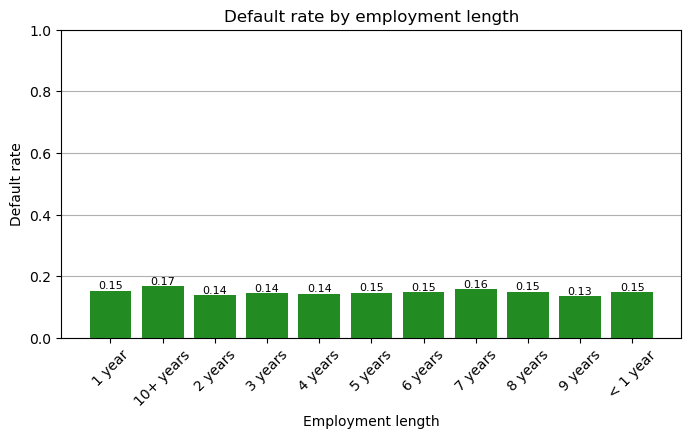

The length of employment has a small impact on the probability of repaying the loan compared to the duration of employment,
but it is worth noting that the longer the period of employment, the greater the probability, although it is small but it is there.


In [17]:
def_rate_el = df[df['loan_status'] == 'Charged Off'].groupby('emp_length').size() / df.groupby('emp_length').size()

plt.figure(figsize=(8, 4))
plt.bar(def_rate_el.index, def_rate_el.values, color='forestgreen')
plt.xlabel('Employment length')
plt.ylabel('Default rate')
plt.title('Default rate by employment length')
plt.xticks(rotation=45)
plt.grid(axis='y')
plt.ylim(0, 1)

for i, value in enumerate(def_rate_el.values):
    plt.text(i, value, f'{value:.2f}', ha='center', va='bottom', fontsize=8)

plt.show()

print('The length of employment has a small impact on the probability of repaying the loan compared to the duration of employment,\n'
    'but it is worth noting that the longer the period of employment, the greater the probability, although it is small but it is there.')

In [18]:
# Test Chi.

# Contingency table.
contingency_table = pd.crosstab(df['loan_status'], df['emp_length'])

# Performing chi-squared test.
chi2, p, dof, expected = chi2_contingency(contingency_table)

alpha = 0.05
print(60 * '#')
print("Chi-square statistic:", chi2)
print("p-value:", p)
print("Degrees of freedom:", dof)
print(60 * '#')
if p < alpha:
    print("There is a significant relationship between employment length and loan status.")
else:
    print("There is no significant relationship between employment length and loan status.")
print(60 * '#')
print("Expected frequencies table:\n", expected)

############################################################
Chi-square statistic: 34.800648784353555
p-value: 0.0001350317375492192
Degrees of freedom: 10
############################################################
There is a significant relationship between employment length and loan status.
############################################################
Expected frequencies table:
 [[ 543.00536433 1584.40830059  717.05136108  659.59047597  551.77570995
   522.74284168  358.97931911  283.52410418  240.73086606  202.62522645
   762.5664306 ]
 [3047.99463567 8893.59169941 4024.94863892 3702.40952403 3097.22429005
  2934.25715832 2015.02068089 1591.47589582 1351.26913394 1137.37477355
  4280.4335694 ]]


How is the size of the loan requested related to the probability of default?

max loan_amnt: 35000.0


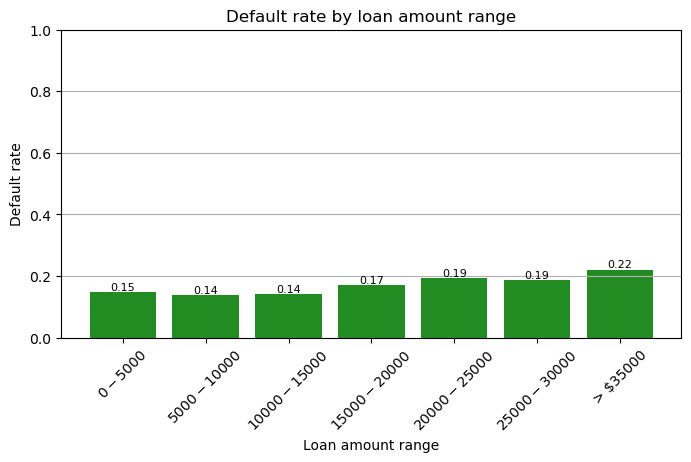

According to the data presented, it can be seen that the larger the loan amount, the greater the probability of repaying it.


In [19]:
print('max loan_amnt:', df['loan_amnt'].max())

loan_bins = list(range(0, 35001, 5000))
loan_labels = [f'${i} - ${i + 5000}' for i in range(0, 30000, 5000)]
loan_labels.append(f'> ${loan_bins[-1]}')

df['loan_range'] = pd.cut(df['loan_amnt'], bins=loan_bins, labels=loan_labels)

def_rate_lr = df[df['loan_status'] == 'Charged Off'].groupby('loan_range').size() / df.groupby('loan_range').size()

plt.figure(figsize=(8, 4))
plt.bar(def_rate_lr.index, def_rate_lr.values, color='forestgreen')
plt.xlabel('Loan amount range')
plt.ylabel('Default rate')
plt.title('Default rate by loan amount range')
plt.xticks(rotation=45)
plt.grid(axis='y')
plt.ylim(0, 1)

for i, value in enumerate(def_rate_lr.values):
    plt.text(i, value, f'{value:.2f}', ha='center', va='bottom', fontsize=8)

plt.show()

print('According to the data presented, it can be seen that the larger the loan amount, the greater the probability of repaying it.')

In [20]:
# Test Chi.

# Contingency table.
contingency_table = pd.crosstab(df['loan_status'], df['loan_range'])

# Performing chi-squared test.
chi2, p, dof, expected = chi2_contingency(contingency_table)

alpha = 0.05
print(60 * '#')
print("Chi-square statistic:", chi2)
print("p-value:", p)
print("Degrees of freedom:", dof)
print(60 * '#')
if p < alpha:
    print("There is a significant relationship between loan amount range and loan status.")
else:
    print("There is no significant relationship between loan amount range and loan status.")
print(60 * '#')

############################################################
Chi-square statistic: 120.04426705888612
p-value: 1.595070967632959e-23
Degrees of freedom: 6
############################################################
There is a significant relationship between loan amount range and loan status.
############################################################


#### Feature Engineering

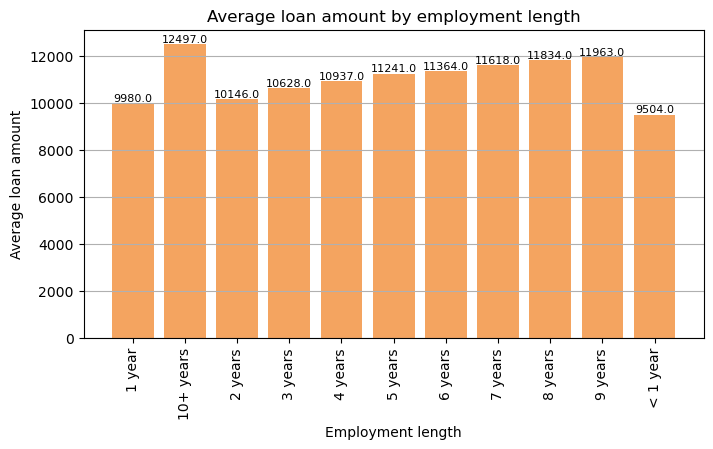

In [21]:
# Average loan amount granted by the client depending on the period of employmen.

avg_loan_amnt = df.groupby('emp_length')['loan_amnt'].mean()

plt.figure(figsize=(8, 4))
plt.bar(avg_loan_amnt.index, avg_loan_amnt.values, color='sandybrown')
plt.xlabel('Employment length')
plt.ylabel('Average loan amount')
plt.title('Average loan amount by employment length')
plt.xticks(avg_loan_amnt.index, rotation=90) 
plt.grid(axis='y')
for index, value in enumerate(avg_loan_amnt.values):
    plt.text(index, value, str(round(value, 0)), ha='center', va='bottom', fontsize=8)

plt.show()

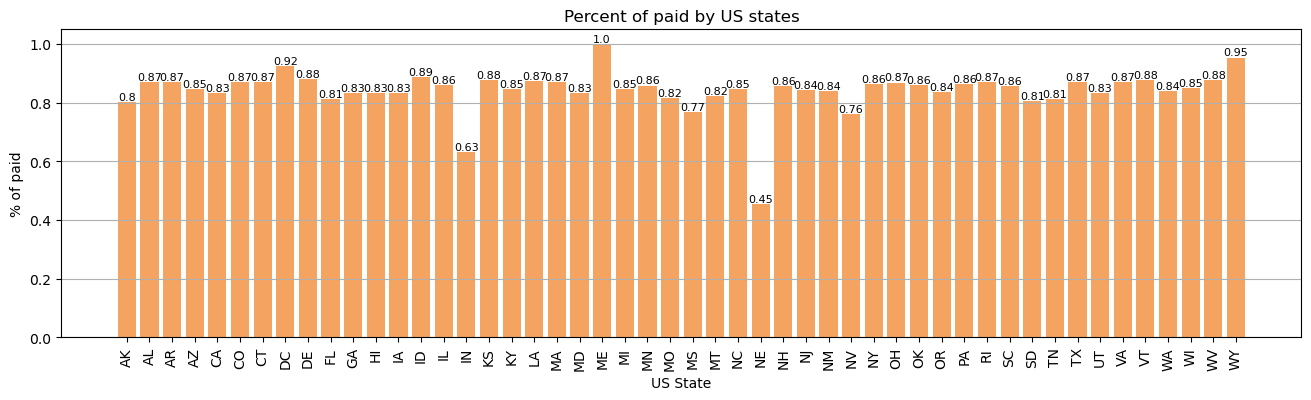

In [22]:
# Number % of repaid loans by state.

fully_paid_rate_by_state = df[df['loan_status'] == 'Fully Paid'].groupby('addr_state').size() / df.groupby('addr_state').size()

plt.figure(figsize=(16, 4))
plt.bar(fully_paid_rate_by_state.index, fully_paid_rate_by_state.values, color='sandybrown')
plt.xlabel('US State')
plt.ylabel('% of paid')
plt.title('Percent of paid by US states')
plt.xticks(fully_paid_rate_by_state.index, rotation=90) 
plt.grid(axis='y')
for index, value in enumerate(fully_paid_rate_by_state.values):
    plt.text(index, value, str(round(value, 2)), ha='center', va='bottom', fontsize=8)

plt.show()

posx and posy should be finite values
posx and posy should be finite values


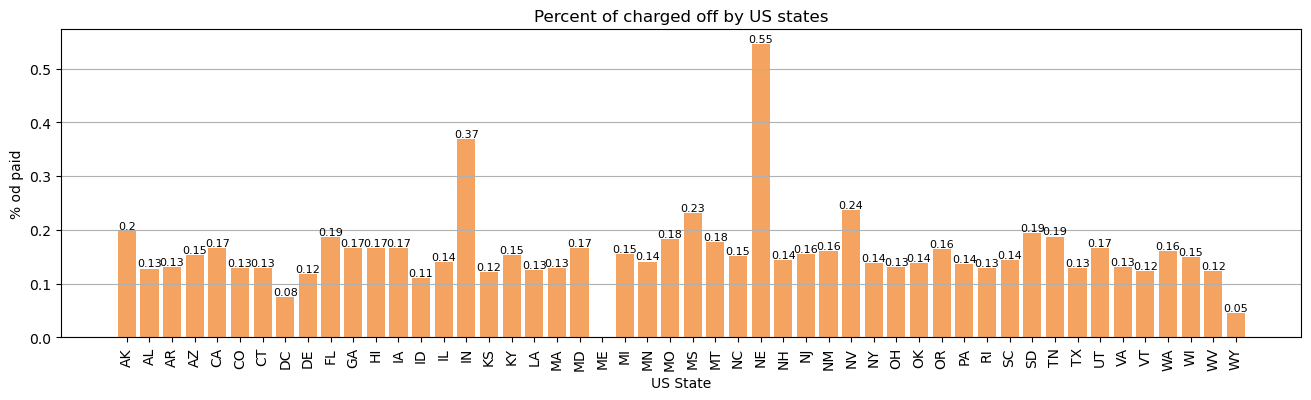

In [23]:
# Number % of outstanding loans by state.

charged_rate_by_state = df[df['loan_status'] == 'Charged Off'].groupby('addr_state').size() / df.groupby('addr_state').size()

plt.figure(figsize=(16, 4))
plt.bar(charged_rate_by_state.index, charged_rate_by_state.values, color='sandybrown')
plt.xlabel('US State')
plt.ylabel('% od paid')
plt.title('Percent of charged off by US states')
plt.xticks(charged_rate_by_state.index, rotation=90) 
plt.grid(axis='y')
for index, value in enumerate(charged_rate_by_state.values):
    plt.text(index, value, str(round(value, 2)), ha='center', va='bottom', fontsize=8)

plt.show()

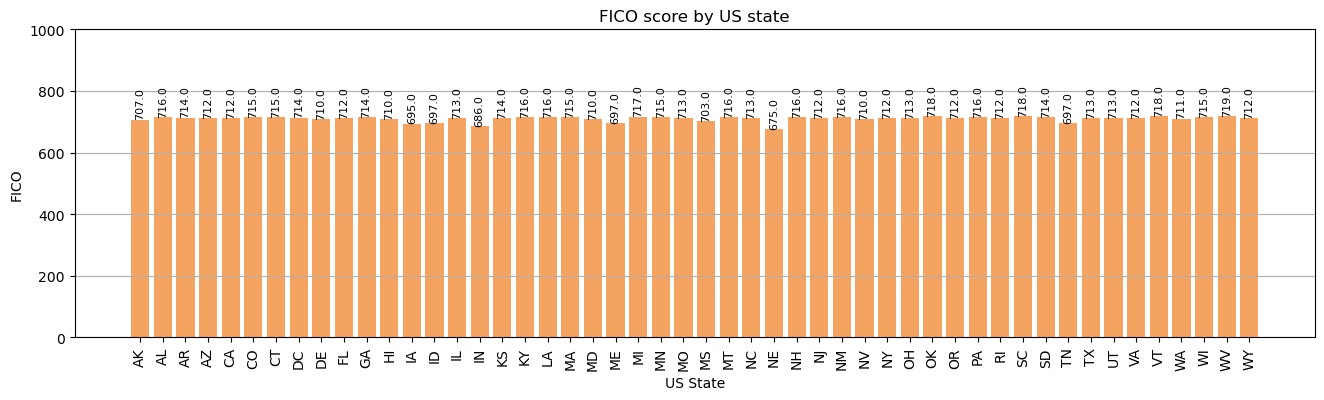

In [24]:
# FICO score by US state.

avg_fico_by_state = df.groupby('addr_state')['fico_range_low'].mean()

plt.figure(figsize=(16, 4))
plt.bar(avg_fico_by_state.index, avg_fico_by_state.values, color='sandybrown')
plt.xlabel('US State')
plt.ylabel('FICO')
plt.title('FICO score by US state')
plt.xticks(avg_fico_by_state.index, rotation=90) 
plt.grid(axis='y')
plt.ylim(0, 1000)

for index, value in enumerate(avg_fico_by_state.values):
    plt.text(index, value, str(round(value, 0)), ha='center', va='bottom', fontsize=8, rotation=90)

plt.show()

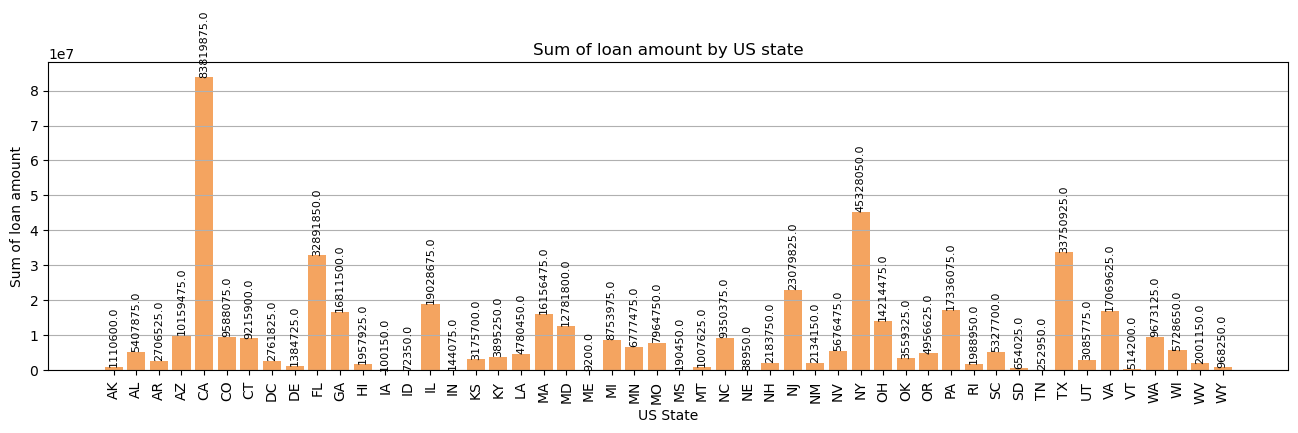

In [25]:
# Loan amount by state.

total_loan_amnt_by_state = df.groupby('addr_state')['loan_amnt'].sum()

plt.figure(figsize=(16, 4))
plt.bar(total_loan_amnt_by_state.index, total_loan_amnt_by_state.values, color='sandybrown')
plt.xlabel('US State')
plt.ylabel('Sum of loan amount')
plt.title('Sum of loan amount by US state')
plt.xticks(total_loan_amnt_by_state.index, rotation=90) 
plt.grid(axis='y')

for index, value in enumerate(total_loan_amnt_by_state.values):
    plt.text(index, value, str(round(value, 0)), ha='center', va='bottom', fontsize=8, rotation=90)

plt.show()

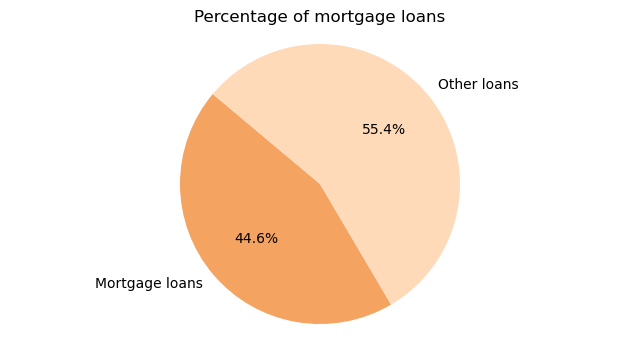

In [26]:
# Percentage of mortgage loans in total loans granted.

total_loans = df.shape[0]

total_mortgage_loans = df[df['home_ownership'] == 'MORTGAGE'].shape[0]
mortgage_loan_percentage = (total_mortgage_loans / total_loans) * 100

labels = ['Mortgage loans', 'Other loans']
sizes = [mortgage_loan_percentage, 100 - mortgage_loan_percentage]
colors = ['sandybrown', 'peachpuff']

plt.figure(figsize=(8, 4))
plt.pie(sizes, labels=labels, colors=colors, autopct='%1.1f%%', startangle=140)
plt.axis('equal')
plt.title('Percentage of mortgage loans')
plt.show()

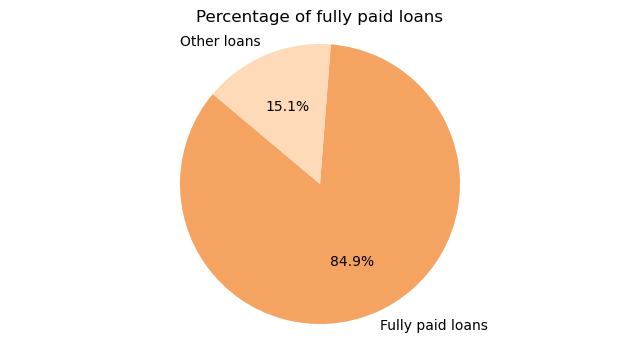

In [27]:
# Percentage of fully paid loans.

total_loans = df.shape[0]

total_fully_paid_loans = df[df['loan_status'] == 'Fully Paid'].shape[0]
loan_percentage = (total_fully_paid_loans / total_loans) * 100

labels = ['Fully paid loans', 'Other loans']
sizes = [loan_percentage, 100 - loan_percentage]
colors = ['sandybrown', 'peachpuff']

plt.figure(figsize=(8, 4))
plt.pie(sizes, labels=labels, colors=colors, autopct='%1.1f%%', startangle=140)
plt.axis('equal')
plt.title('Percentage of fully paid loans')
plt.show()

Fico score:
< 580: Poor
580 - 669: Fair
670 - 739: Good
740 - 799: Very Good
800+: Exceptional
FICO scores in dataset:  [3 4 2 5]


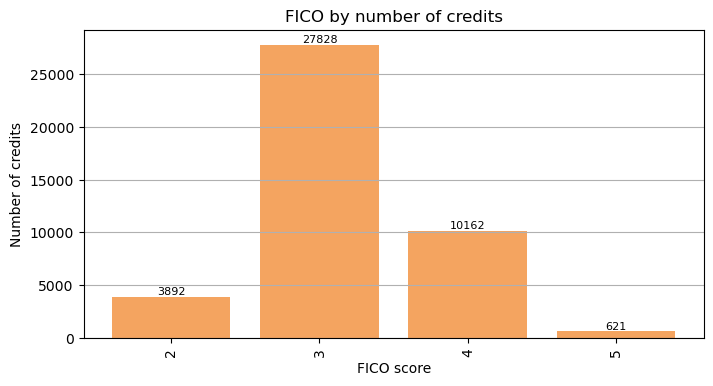

In [28]:
# Borrower rating according to FICO index 1 (poor) - 5 (exceptional).

def fico(score):
    if score >= 800:
        return 5
    elif score < 800 and score >= 740:
        return 4
    elif score < 740 and score >= 670:
        return 3
    elif score < 670 and score >= 580:
        return 2
    elif score < 580:
        return 1
    
df['fico_score'] = df['fico_range_low'].apply(fico)
fico_values = df['fico_score'].unique()

print('Fico score:\n< 580: Poor\n580 - 669: Fair\n670 - 739: Good\n740 - 799: Very Good\n800+: Exceptional')
print('FICO scores in dataset: ', fico_values)

plt.figure(figsize=(8, 4))
bars = plt.bar(fico_values, df['fico_score'].value_counts(), color='sandybrown')

plt.xlabel('FICO score')
plt.ylabel('Number of credits')
plt.title('FICO by number of credits')
plt.xticks(fico_values, rotation=90) 
plt.grid(axis='y')

for bar in bars:
    plt.text(bar.get_x() + bar.get_width()/2, bar.get_height(), bar.get_height(), 
             ha='center', va='bottom', fontsize=8)

plt.show()

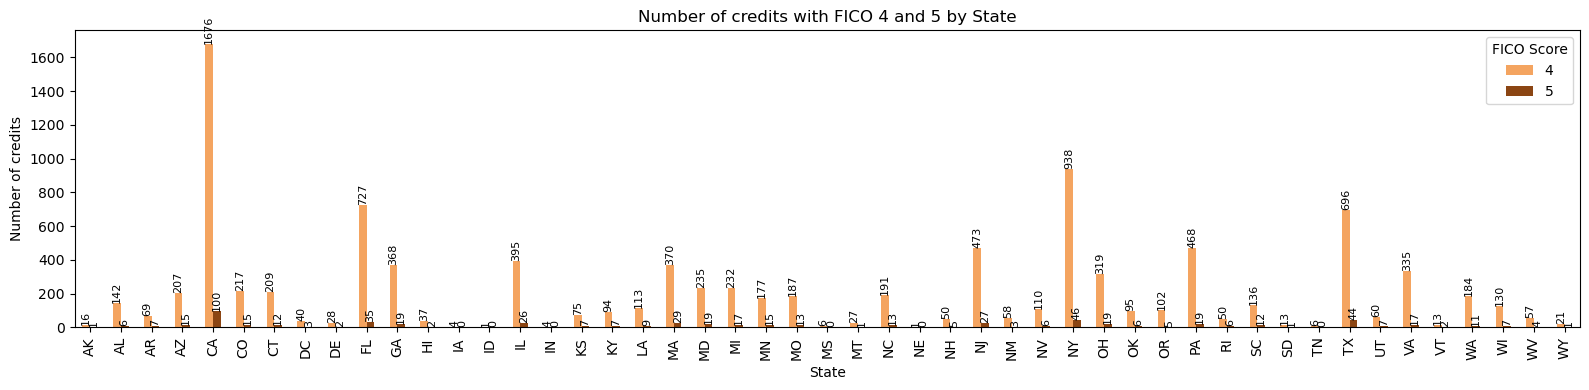

In [29]:
# Very good and exceptional borrowers by state.

fico_best_state_counts = df[df['fico_score'].isin([4, 5])].groupby('addr_state')['fico_score'].value_counts().unstack(fill_value=0)

ax = fico_best_state_counts.plot(kind='bar', figsize=(16, 4))

num_states = len(fico_best_state_counts)
for i, patch in enumerate(ax.patches):
    if i < num_states:
        patch.set_facecolor('sandybrown') 
    else:
        patch.set_facecolor('saddlebrown')

plt.xlabel('State')
plt.ylabel('Number of credits')
plt.title('Number of credits with FICO 4 and 5 by State')
plt.legend(title='FICO Score')
plt.tight_layout()

for p in ax.patches:
    ax.text(p.get_x() + p.get_width()/2., p.get_height(), '%d' % int(p.get_height()), 
            fontsize=8, ha='center', va='bottom', rotation=90)

plt.show()

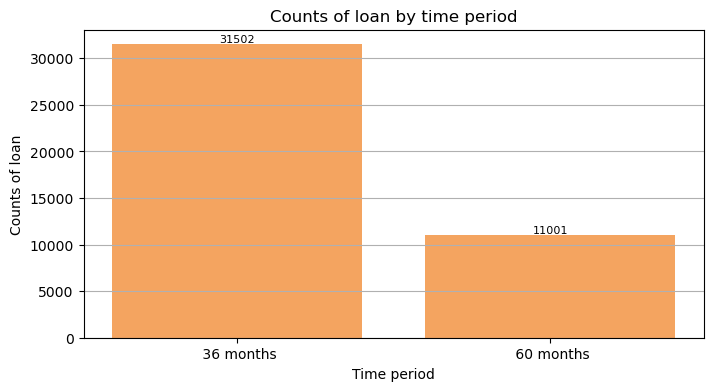

In [30]:
# Number of loans in the loan repayment period.

number_loans_time_period = df.groupby('term')['loan_amnt'].count()

plt.figure(figsize=(8, 4))
plt.bar(number_loans_time_period.index, number_loans_time_period.values, color='sandybrown')
plt.xlabel('Time period')
plt.ylabel('Counts of loan')
plt.title('Counts of loan by time period')
plt.xticks(number_loans_time_period.index) 
plt.grid(axis='y')

for index, value in enumerate(number_loans_time_period.values):
    plt.text(index, value, str(round(value, 0)), ha='center', va='bottom', fontsize=8)

plt.show()

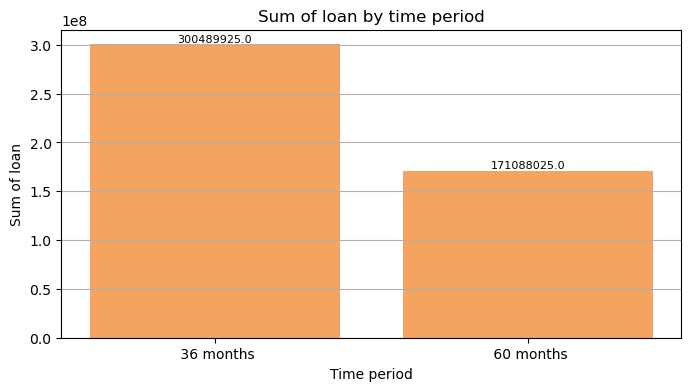

In [31]:
# Sum amount of loans amount in the loan repayment period.

sum_loans_by_term = df.groupby('term')['loan_amnt'].sum()

plt.figure(figsize=(8, 4))
plt.bar(sum_loans_by_term.index, sum_loans_by_term.values, color='sandybrown')
plt.xlabel('Time period')
plt.ylabel('Sum of loan')
plt.title('Sum of loan by time period')
plt.xticks(sum_loans_by_term.index) 
plt.grid(axis='y')

for index, value in enumerate(sum_loans_by_term.values):
    plt.text(index, value, str(round(value, 0)), ha='center', va='bottom', fontsize=8)

plt.show()

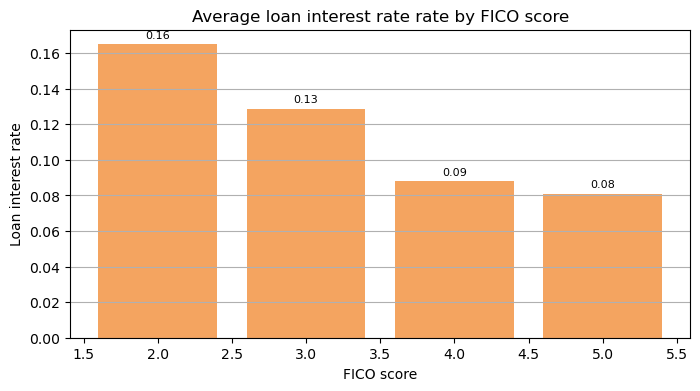

In [32]:
# Average loan interest rate by FICO score.

avg_loan_rate_fico = df.groupby('fico_score')['int_rate'].mean()

fig, ax = plt.subplots(figsize=(8, 4))  

bars = ax.bar(avg_loan_rate_fico.index, avg_loan_rate_fico.values, color='sandybrown')

ax.set_xlabel('FICO score')
ax.set_ylabel('Loan interest rate')
ax.set_title('Average loan interest rate rate by FICO score')
ax.grid(axis='y')

for bar in bars:
    height = bar.get_height()
    ax.annotate(f'{height:.2f}',
                xy=(bar.get_x() + bar.get_width() / 2, height),
                xytext=(0, 3),
                textcoords="offset points",
                ha='center', va='bottom', fontsize=8)

plt.show()

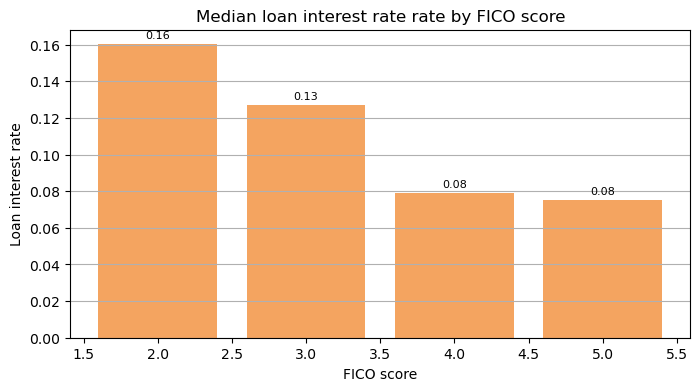

In [33]:
# Median loan interest rate by FICO score.

median_loan_rate_fico = df.groupby('fico_score')['int_rate'].median()

fig, ax = plt.subplots(figsize=(8, 4))  

bars = ax.bar(median_loan_rate_fico.index, median_loan_rate_fico.values, color='sandybrown')

ax.set_xlabel('FICO score')
ax.set_ylabel('Loan interest rate')
ax.set_title('Median loan interest rate rate by FICO score')
ax.grid(axis='y')

for bar in bars:
    height = bar.get_height()
    ax.annotate(f'{height:.2f}',
                xy=(bar.get_x() + bar.get_width() / 2, height),
                xytext=(0, 3),
                textcoords="offset points",
                ha='center', va='bottom', fontsize=8)

plt.show()

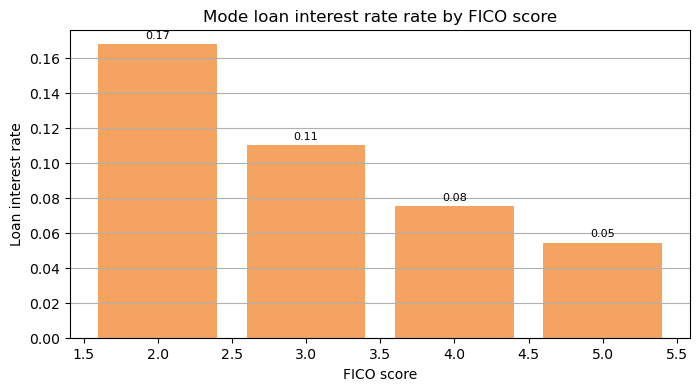

In [34]:
# Mode loan interest rate by FICO score.

mode_loan_rate_fico = df.groupby('fico_score')['int_rate'].agg(pd.Series.mode)

fig, ax = plt.subplots(figsize=(8, 4))  

bars = ax.bar(mode_loan_rate_fico.index, mode_loan_rate_fico.values, color='sandybrown')

ax.set_xlabel('FICO score')
ax.set_ylabel('Loan interest rate')
ax.set_title('Mode loan interest rate rate by FICO score')
ax.grid(axis='y')

for bar in bars:
    height = bar.get_height()
    ax.annotate(f'{height:.2f}',
                xy=(bar.get_x() + bar.get_width() / 2, height),
                xytext=(0, 3),
                textcoords="offset points",
                ha='center', va='bottom', fontsize=8)

plt.show()

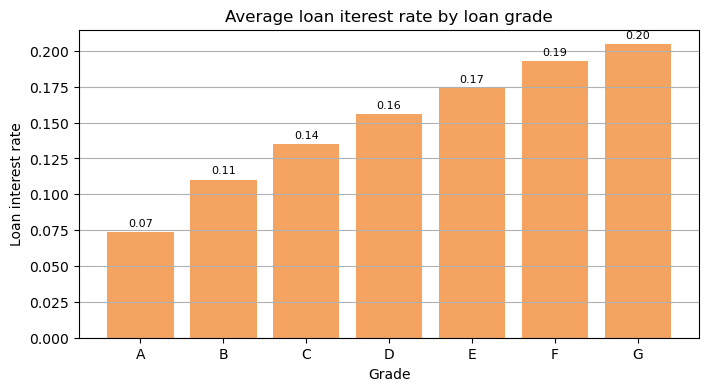

In [35]:
# Average loan interest rate by loan grade.

avg_loan_rate_grade = df.groupby('grade')['int_rate'].mean()

fig, ax = plt.subplots(figsize=(8, 4))  

bars = ax.bar(avg_loan_rate_grade.index, avg_loan_rate_grade.values, color='sandybrown')

ax.set_xlabel('Grade')
ax.set_ylabel('Loan interest rate')
ax.set_title('Average loan iterest rate by loan grade')
ax.grid(axis='y')

for bar in bars:
    height = bar.get_height()
    ax.annotate(f'{height:.2f}',
                xy=(bar.get_x() + bar.get_width() / 2, height),
                xytext=(0, 3),
                textcoords="offset points",
                ha='center', va='bottom', fontsize=8)

plt.show()

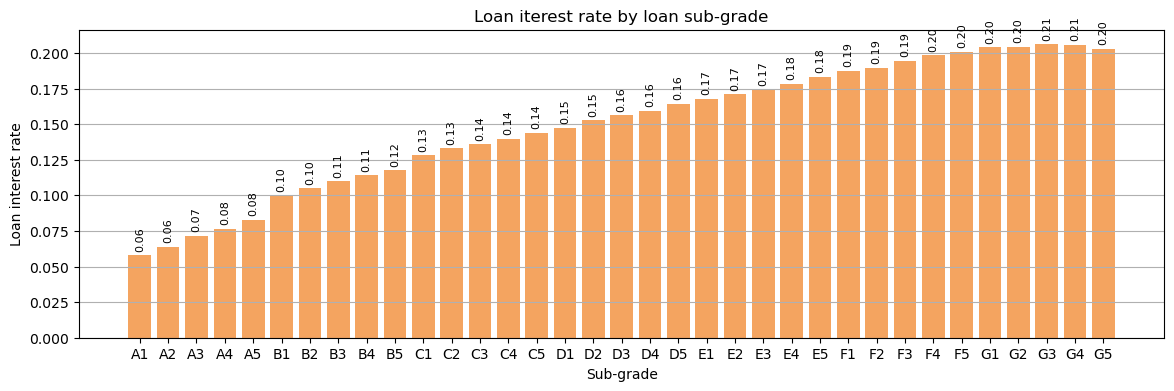

In [36]:
# Average loan interest rate by loan sub-grade.

avg_loan_rate_sub_grade = df.groupby('sub_grade')['int_rate'].mean()

fig, ax = plt.subplots(figsize=(14, 4))  

bars = ax.bar(avg_loan_rate_sub_grade.index, avg_loan_rate_sub_grade.values, color='sandybrown')

ax.set_xlabel('Sub-grade')
ax.set_ylabel('Loan interest rate')
ax.set_title('Loan iterest rate by loan sub-grade')
ax.grid(axis='y')

for bar in bars:
    height = bar.get_height()
    ax.annotate(f'{height:.2f}',
                xy=(bar.get_x() + bar.get_width() / 2, height),
                xytext=(0, 3),
                textcoords="offset points",
                ha='center', va='bottom', fontsize=8, rotation=90)

plt.show()

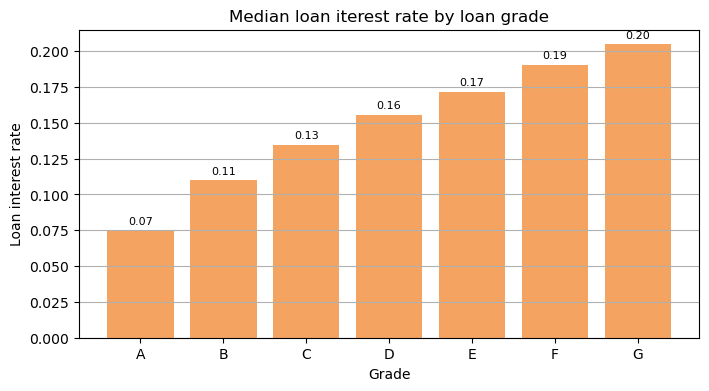

In [37]:
# Median loan interest rate by loan grade,

median_loan_rate_grade = df.groupby('grade')['int_rate'].median()

fig, ax = plt.subplots(figsize=(8, 4))  

bars = ax.bar(median_loan_rate_grade.index, median_loan_rate_grade.values, color='sandybrown')

ax.set_xlabel('Grade')
ax.set_ylabel('Loan interest rate')
ax.set_title('Median loan iterest rate by loan grade')
ax.grid(axis='y')

for bar in bars:
    height = bar.get_height()
    ax.annotate(f'{height:.2f}',
                xy=(bar.get_x() + bar.get_width() / 2, height),
                xytext=(0, 3),
                textcoords="offset points",
                ha='center', va='bottom', fontsize=8)

plt.show()

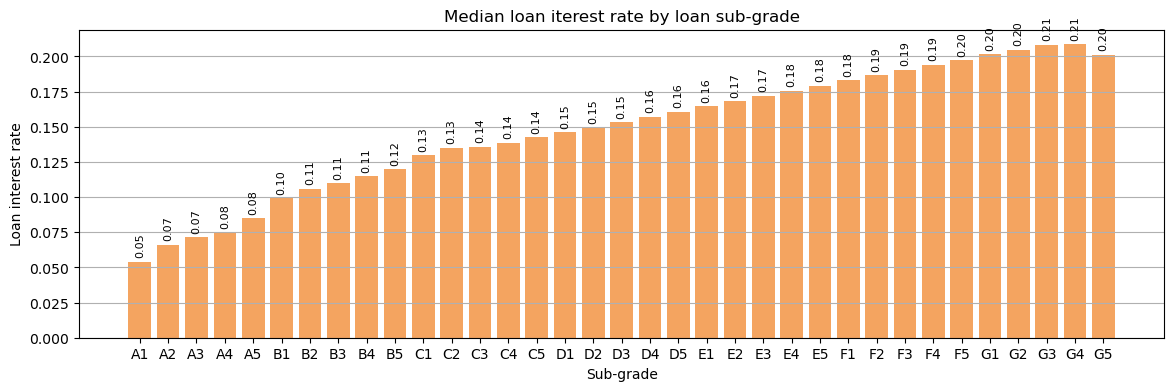

In [38]:
# Median loan interest rate by loan sub-grade.

median_loan_rate_sub_grade = df.groupby('sub_grade')['int_rate'].median()

fig, ax = plt.subplots(figsize=(14, 4))  

bars = ax.bar(median_loan_rate_sub_grade.index, median_loan_rate_sub_grade.values, color='sandybrown')

ax.set_xlabel('Sub-grade')
ax.set_ylabel('Loan interest rate')
ax.set_title('Median loan iterest rate by loan sub-grade')
ax.grid(axis='y')

for bar in bars:
    height = bar.get_height()
    ax.annotate(f'{height:.2f}',
                xy=(bar.get_x() + bar.get_width() / 2, height),
                xytext=(0, 3),
                textcoords="offset points",
                ha='center', va='bottom', fontsize=8, rotation=90)

plt.show()

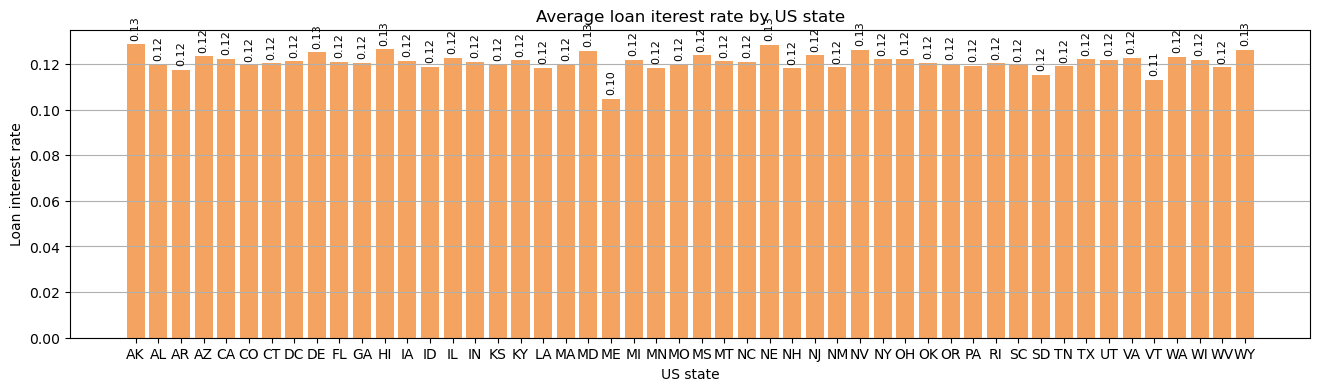

In [39]:
# Average loan interest rate by US state.

avg_loan_rate_state = df.groupby('addr_state')['int_rate'].mean()

fig, ax = plt.subplots(figsize=(16, 4))  

bars = ax.bar(avg_loan_rate_state.index, avg_loan_rate_state.values, color='sandybrown')

ax.set_xlabel('US state')
ax.set_ylabel('Loan interest rate')
ax.set_title('Average loan iterest rate by US state')
ax.grid(axis='y')

for bar in bars:
    height = bar.get_height()
    ax.annotate(f'{height:.2f}',
                xy=(bar.get_x() + bar.get_width() / 2, height),
                xytext=(0, 3),
                textcoords="offset points",
                ha='center', va='bottom', fontsize=8, rotation=90)

plt.show()

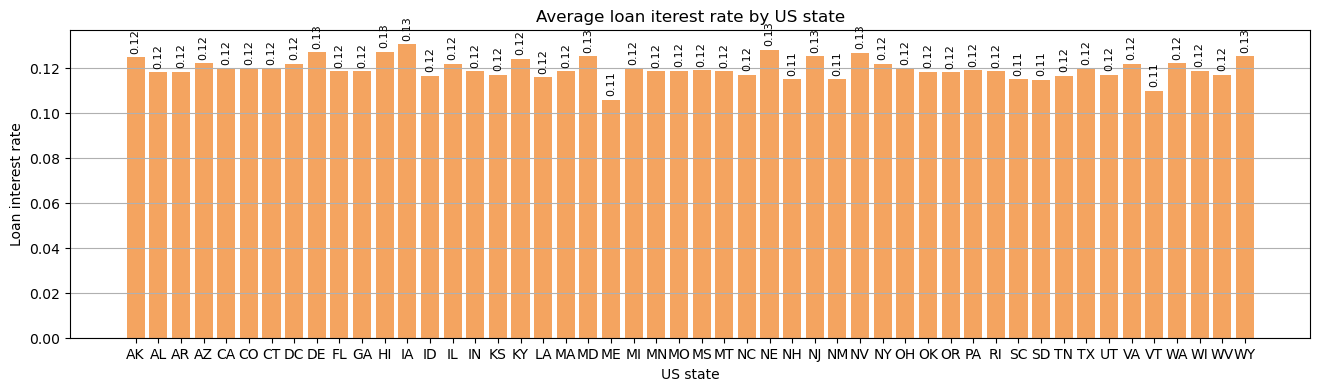

In [40]:
# Median loan interest rate by US state.

median_loan_rate_state = df.groupby('addr_state')['int_rate'].median()

fig, ax = plt.subplots(figsize=(16, 4))  

bars = ax.bar(median_loan_rate_state.index, median_loan_rate_state.values, color='sandybrown')

ax.set_xlabel('US state')
ax.set_ylabel('Loan interest rate')
ax.set_title('Average loan iterest rate by US state')
ax.grid(axis='y')

for bar in bars:
    height = bar.get_height()
    ax.annotate(f'{height:.2f}',
                xy=(bar.get_x() + bar.get_width() / 2, height),
                xytext=(0, 3),
                textcoords="offset points",
                ha='center', va='bottom', fontsize=8, rotation=90)

plt.show()

### Modeling

##### Cluster the data (try several methods, at least 3) and check whether there are any borrower segments, use appropriate methods to determine the optimal number of clusters

Dimension reduction - PCA

In [42]:
data = df
data.head()

loan_amnt        term  int_rate  installment grade sub_grade emp_length  \
0     5000.0   36 months    0.1065       162.87     B        B2  10+ years   
1     2500.0   60 months    0.1527        59.83     C        C4   < 1 year   
2     2400.0   36 months    0.1596        84.33     C        C5  10+ years   
3    10000.0   36 months    0.1349       339.31     C        C1  10+ years   
4     3000.0   60 months    0.1269        67.79     B        B5     1 year   

  home_ownership  annual_inc verification_status  loan_status         purpose  \
0           RENT     24000.0            Verified   Fully Paid     credit_card   
1           RENT     30000.0     Source Verified  Charged Off             car   
2           RENT     12252.0        Not Verified   Fully Paid  small_business   
3           RENT     49200.0     Source Verified   Fully Paid           other   
4           RENT     80000.0     Source Verified   Fully Paid           other   

  zip_code addr_state    dti  delinq_2yrs  fico_range_low  inq_last_6mths  \
0    860xx         AZ  27.65          0.0           735.0             1.0   
1    309xx         GA   1.00          0.0           740.0             5.0   
2    606xx         IL   8.72          0.0           735.0             2.0   
3    917xx         CA  20.00          0.0           690.0             1.0   
4    972xx         OR  17.94          0.0           695.0             0.0   

   open_acc  pub_rec  revol_bal  revol_util  total_acc   total_pymnt  \
0       3.0      0.0    13648.0       0.837        9.0   5863.155187   
1       3.0      0.0     1687.0       0.094        4.0   1014.530000   
2       2.0      0.0     2956.0       0.985       10.0   3005.666844   
3      10.0      0.0     5598.0       0.210       37.0  12231.890000   
4      15.0      0.0    27783.0       0.539       38.0   4066.908161   

   total_pymnt_inv  total_rec_prncp  total_rec_int  total_rec_late_fee  \
0          5833.84          5000.00         863.16                0.00   
1          1014.53           456.46         435.17                0.00   
2          3005.67          2400.00         605.67                0.00   
3         12231.89         10000.00        2214.92               16.97   
4          4066.91          3000.00        1066.91                0.00   

   collection_recovery_fee  last_pymnt_amnt  acc_now_delinq  delinq_amnt  \
0                     0.00           171.62             0.0          0.0   
1                     1.11           119.66             0.0          0.0   
2                     0.00           649.91             0.0          0.0   
3                     0.00           357.48             0.0          0.0   
4                     0.00            67.30             0.0          0.0   

   pub_rec_bankruptcies  tax_liens debt_settlement_flag  credit_years  \
0                   0.0        0.0                    N            33   
1                   0.0        0.0                    N            17   
2                   0.0        0.0                    N            15   
3                   0.0        0.0                    N            20   
4                   0.0        0.0                    N            22   

      income_range      loan_range  fico_score  
0  $20000 - $40000      $0 - $5000           3  
1  $20000 - $40000      $0 - $5000           4  
2      $0 - $20000      $0 - $5000           3  
3  $40000 - $60000  $5000 - $10000           3  
4  $60000 - $80000      $0 - $5000           3

In [43]:
# Removing other data.
data = data.drop(
    [
        'zip_code',
        'grade',
        'last_pymnt_amnt',
        'total_rec_prncp',
        'total_pymnt_inv',
        'total_rec_int',
        'total_pymnt'
    ], axis=1
)

# Encoded data.
from sklearn.preprocessing import LabelEncoder

cols = data.columns

for c in cols:
    lbl = LabelEncoder() 
    lbl.fit(list(data[c].values)) 
    data[c] = lbl.transform(list(data[c].values))

data.head()

loan_amnt  term  int_rate  installment  sub_grade  emp_length  \
0        164     0        78         4161          6           1   
1         65     1       221          789         13          10   
2         61     0       239         1541         14           1   
3        359     0       160         9677         10           1   
4         85     1       135         1036          9           0   

   home_ownership  annual_inc  verification_status  loan_status  purpose  \
0               4         416                    2            1        1   
1               4         740                    1            0        0   
2               4          75                    0            1       11   
3               4        2106                    1            1        9   
4               4        3929                    1            1        9   

   addr_state   dti  delinq_2yrs  fico_range_low  inq_last_6mths  open_acc  \
0           3  2717            0              25               1         2   
1          10    99            0              26               5         2   
2          14   871            0              25               2         1   
3           4  1999            0              16               1         9   
4          36  1793            0              17               0        14   

   pub_rec  revol_bal  revol_util  total_acc  total_rec_late_fee  \
0        0      11564         930          8                   0   
1        0       1575         122          3                   0   
2        0       2746        1080          9                   0   
3        0       5135         251         36                1097   
4        0      18054         619         37                   0   

   collection_recovery_fee  acc_now_delinq  delinq_amnt  pub_rec_bankruptcies  \
0                        0               0            0                     0   
1                      172               0            0                     0   
2                        0               0            0                     0   
3                        0               0            0                     0   
4                        0               0            0                     0   

   tax_liens  debt_settlement_flag  credit_years  income_range  loan_range  \
0          0                     0            32             6           0   
1          0                     0            16             6           0   
2          0                     0            14             0           0   
3          0                     0            19            17           5   
4          0                     0            21            28           0   

   fico_score  
0           1  
1           2  
2           1  
3           1  
4           1

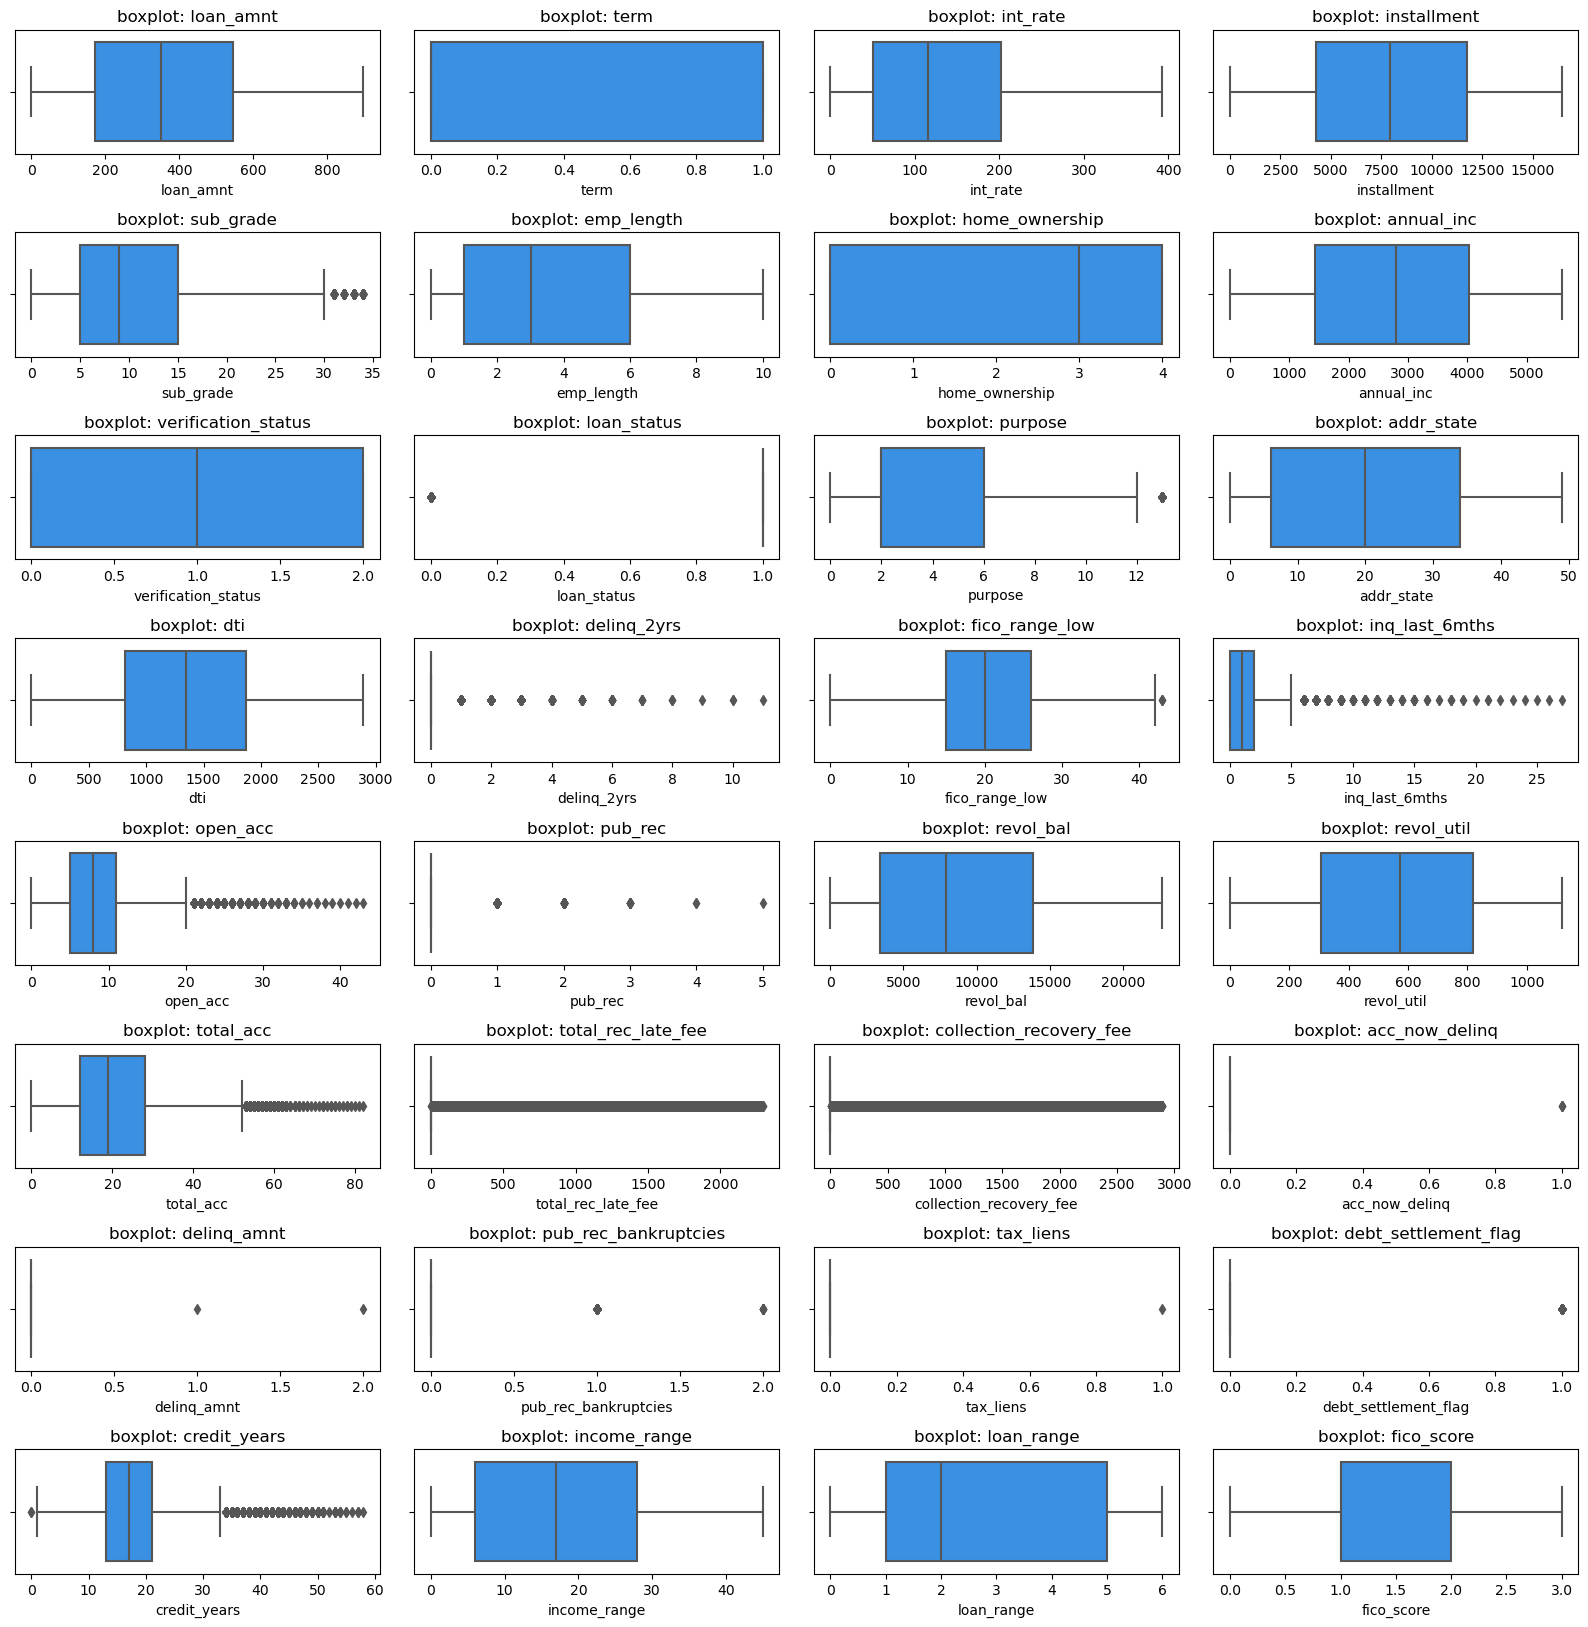

In [44]:
# Data distribution using boxplots.
import seaborn as sns
import matplotlib.pyplot as plt

def plot_boxplots(data, color='dodgerblue', figsize=(4, 2)):
    columns = data.columns
    num_rows = 10
    num_cols = 4
    
    num_plots = len(columns)
    
    fig, axes = plt.subplots(nrows=num_rows, ncols=num_cols, figsize=(figsize[0]*num_cols, figsize[1]*num_rows))
    
    for i, column in enumerate(columns):
        row_index = i // num_cols
        col_index = i % num_cols
        
        sns.boxplot(x=column, data=data, color=color, ax=axes[row_index, col_index])
        axes[row_index, col_index].set_title(f'boxplot: {column}')

    for i in range(num_plots, num_rows*num_cols):
        row_index = i // num_cols
        col_index = i % num_cols
        fig.delaxes(axes[row_index, col_index])
    
    plt.tight_layout()
    plt.show()

plot_boxplots(data, color='dodgerblue')

In [45]:
# Setting up the X and y data for modeling. Loan status is our Y.
X = data.drop(columns=['loan_status'])
y = data['loan_status']

# X value scaling and creating a dataframe from scaled variables before PCA.
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

X_scaled_df = pd.DataFrame(X_scaled,columns=X.columns)
X_scaled_df.head()

loan_amnt      term  int_rate  installment  sub_grade  emp_length  \
0  -0.900038 -0.590945 -0.559772    -0.869674  -0.623255   -0.908765   
1  -1.322060  1.692205  0.910626    -1.618389   0.366595    1.871785   
2  -1.339111 -0.590945  1.095711    -1.451416   0.508002   -0.908765   
3  -0.068784 -0.590945  0.283393     0.355092  -0.057627   -0.908765   
4  -1.236803  1.692205  0.026331    -1.563546  -0.199034   -1.217715   

   home_ownership  annual_inc  verification_status   purpose  addr_state  \
0        0.965253   -1.548162             1.304234 -0.846428   -1.274739   
1        0.965253   -1.333639             0.143510 -1.138296   -0.800784   
2        0.965253   -1.773942            -1.017214  2.072258   -0.529953   
3        0.965253   -0.429196             0.143510  1.488521   -1.207031   
4        0.965253    0.777831             0.143510  1.488521    0.959620   

        dti  delinq_2yrs  fico_range_low  inq_last_6mths  open_acc   pub_rec  \
0  2.058341    -0.298537        0.606848       -0.053268 -1.411501 -0.236696   
1 -1.843733    -0.298537        0.745045        2.589344 -1.411501 -0.236696   
2 -0.693083    -0.298537        0.606848        0.607385 -1.633996 -0.236696   
3  0.988177    -0.298537       -0.636934       -0.053268  0.145968 -0.236696   
4  0.681138    -0.298537       -0.498736       -0.713921  1.258445 -0.236696   

   revol_bal  revol_util  total_acc  total_rec_late_fee  \
0   0.413333    1.201612  -1.132295           -0.209475   
1  -1.144975   -1.411489  -1.563666           -0.209475   
2  -0.962296    1.686717  -1.046021           -0.209475   
3  -0.589606   -0.994298   1.283380            3.399122   
4   1.425789    0.195827   1.369654           -0.209475   

   collection_recovery_fee  acc_now_delinq  delinq_amnt  pub_rec_bankruptcies  \
0                -0.265658       -0.009702    -0.006508             -0.213091   
1                 0.130448       -0.009702    -0.006508             -0.213091   
2                -0.265658       -0.009702    -0.006508             -0.213091   
3                -0.265658       -0.009702    -0.006508             -0.213091   
4                -0.265658       -0.009702    -0.006508             -0.213091   

   tax_liens  debt_settlement_flag  credit_years  income_range  loan_range  \
0  -0.004851             -0.061471      1.987471     -0.891679   -1.186241   
1  -0.004851             -0.061471     -0.217714     -0.891679   -1.186241   
2  -0.004851             -0.061471     -0.493362     -1.386991   -1.186241   
3  -0.004851             -0.061471      0.195758      0.016393    1.206951   
4  -0.004851             -0.061471      0.471406      0.924464   -1.186241   

   fico_score  
0   -0.295445  
1    1.376187  
2   -0.295445  
3   -0.295445  
4   -0.295445

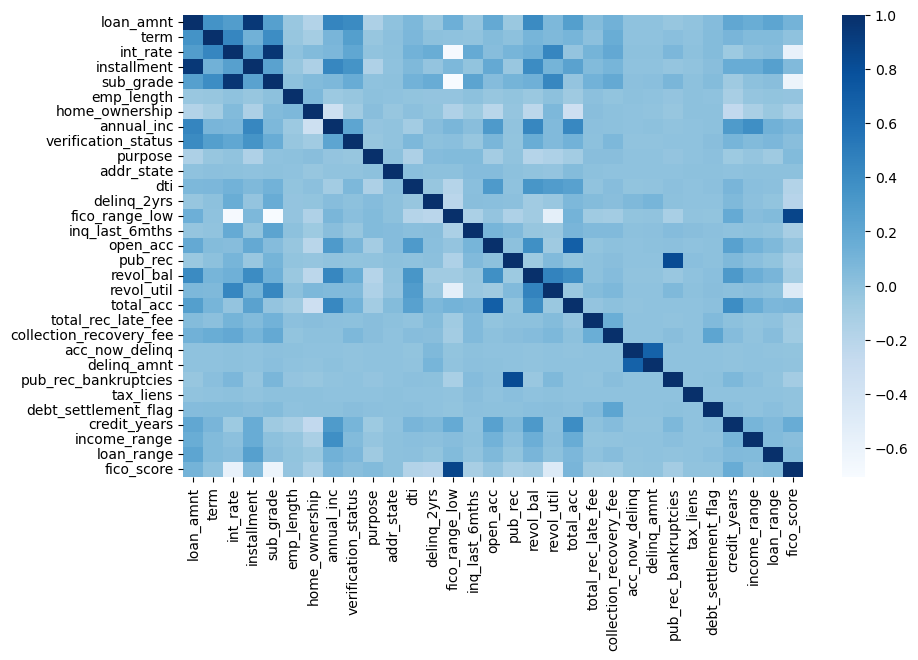

In [46]:
# Correlation plot between X variables.
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))       
sns.heatmap(X_scaled_df.corr(), cmap='Blues')
plt.show()

In [47]:
# Principal Component Analysis (PCA) on X_scaled data.
from sklearn.decomposition import PCA
pca = PCA(random_state=42)
pca.fit(X_scaled)

# The weight indicates how much each feature contributes to the variability towards the first principal component. 
# These values can be positive or negative, indicating whether the feature is positively 
# or negatively correlated with a given principal component.
pca.components_

# Percentage of variance explained by each of the selected principal components.
pca.explained_variance_ratio_

# The cumulative sum of the percentage of variance explained by the subsequent principal components.
import numpy as np

var_cumu = np.cumsum(pca.explained_variance_ratio_)
var_cumu

array([0.13582368, 0.25289314, 0.31549212, 0.37241537, 0.42721906,
       0.47431226, 0.51519605, 0.5523022 , 0.58740414, 0.62031935,
       0.6525023 , 0.6844728 , 0.71545775, 0.74595946, 0.77453576,
       0.80272711, 0.83015249, 0.85446088, 0.87803687, 0.90105723,
       0.92249791, 0.93957997, 0.95126049, 0.9618338 , 0.97235049,
       0.9819786 , 0.98920173, 0.99481905, 0.99800579, 0.99926386,
       1.        ])

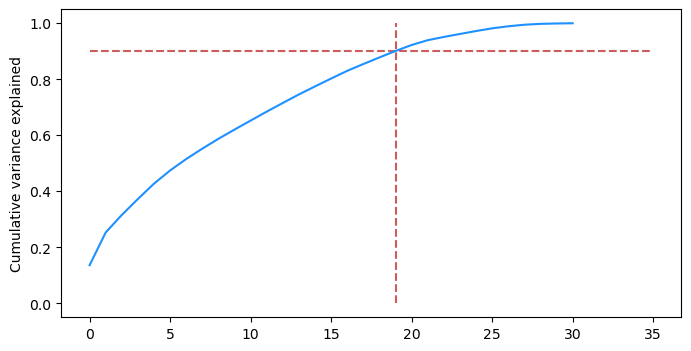

In [48]:
# A graph that shows the cumulative sum of the percentage of variance explained
# by successive principal components in a principal component analysis (PCA).
# The variance is explained for 19 components.

fig = plt.figure(figsize=[8, 4], dpi=100)
plt.vlines(x=19, ymax=1, ymin=0, colors="indianred", linestyles="--")
plt.hlines(y=0.90, xmax=35, xmin=0, colors="indianred", linestyles="--")
plt.plot(var_cumu, color="dodgerblue")
plt.ylabel("Cumulative variance explained")
plt.show()

In [49]:
# PCA (Principal Component Analysis) using the IncrementalPCA class from the scikit-learn library. 
# IncrementalPCA allows you to fit the PCA model to large data sets that do not fit in RAM.

from sklearn.decomposition import IncrementalPCA
pca_final = IncrementalPCA(n_components=19)
X_pca_final = pca_final.fit_transform(X_scaled)

print(X.shape)
print(X_pca_final.shape)

# Correlation matrix between principal components (PCA) in X_pca_final data.

corrmat = np.corrcoef(X_pca_final.transpose())
print(corrmat.shape)

print('\nFrom', len(data.columns), 'variables IncrementalPCA creates', corrmat.shape[0], 'variables.')

(42503, 31)
(42503, 19)
(19, 19)

From 32 variables IncrementalPCA creates 19 variables.


<Axes: >

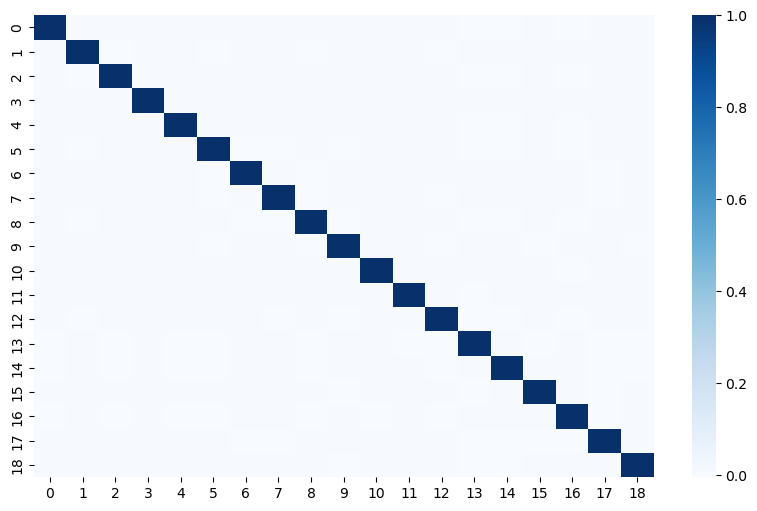

In [50]:
# Principal comonents correlation chart. 
# There should be a very low correlation between the principal components.

plt.figure(figsize=[10, 6])
sns.heatmap(corrmat, cmap='Blues')

In [51]:
# Comparison of the PCA between components.

colnames = list(X.columns)
pca_df = pd.DataFrame(
    {
        'PC1':pca.components_[0], 
        'PC2':pca.components_[1],
        'Feature':colnames})
pca_df

PC1       PC2                  Feature
0   0.302380 -0.253248                loan_amnt
1   0.200749 -0.017972                     term
2   0.365520  0.258764                 int_rate
3   0.290212 -0.232883              installment
4   0.362196  0.271450                sub_grade
5  -0.032471  0.054039               emp_length
6  -0.093431  0.227394           home_ownership
7   0.220050 -0.277162               annual_inc
8   0.184438 -0.113094      verification_status
9  -0.090939  0.051151                  purpose
10  0.002835 -0.010151               addr_state
11  0.161670  0.002703                      dti
12  0.060273  0.082665              delinq_2yrs
13 -0.254095 -0.385878           fico_range_low
14  0.069486  0.063712           inq_last_6mths
15  0.180074 -0.212508                 open_acc
16  0.050480  0.097817                  pub_rec
17  0.284028 -0.183621                revol_bal
18  0.258857  0.191007               revol_util
19  0.183798 -0.291311                total_acc
20  0.052738  0.048198       total_rec_late_fee
21  0.108506  0.042656  collection_recovery_fee
22  0.000428  0.015488           acc_now_delinq
23  0.003694  0.013933              delinq_amnt
24  0.050392  0.082087     pub_rec_bankruptcies
25 -0.000490  0.008824                tax_liens
26  0.036213  0.006111     debt_settlement_flag
27  0.112833 -0.238661             credit_years
28  0.100113 -0.136699             income_range
29  0.082942 -0.101702               loan_range
30 -0.234734 -0.355942               fico_score

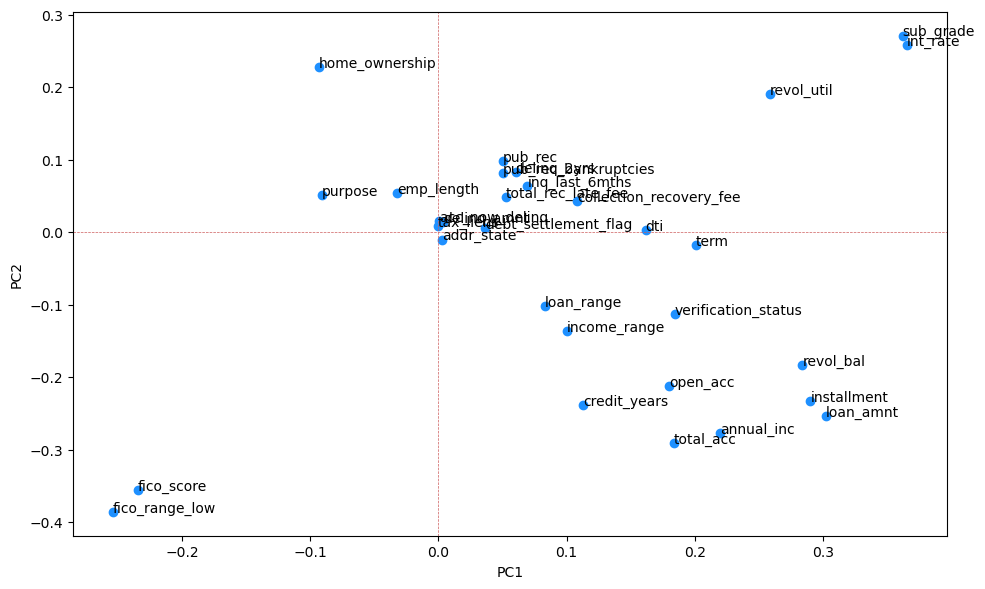

In [52]:
# Scatter plot for the first two principal components (PC1 and PC2) contained in the pca_df data frame.
# If 0, it does not play a significant role for the main component.

fig = plt.figure(figsize=(10, 6))
plt.scatter(pca_df['PC1'], pca_df['PC2'], color='dodgerblue')
plt.xlabel('PC1')
plt.ylabel('PC2')

plt.axhline(0, linestyle='--', color='indianred', linewidth=0.5)
plt.axvline(0, linestyle='--', color='indianred', linewidth=0.5)

for i, txt in enumerate(pca_df.Feature):
    plt.annotate(txt, (pca_df.PC1[i], pca_df.PC2[i]))

plt.tight_layout()
plt.show()

##### Clustering

In [53]:
import warnings
warnings.filterwarnings("ignore")

# I tried 5 clustering method: K-Means, Hierarchical, Agglomeratice, DBSCAN and Mean Shift.
# For Hierarchical, Agglomeratice and Mean Shift my PC was burned, and I didn't have too much RAM for work :D
# That's why I show only 2 methods.

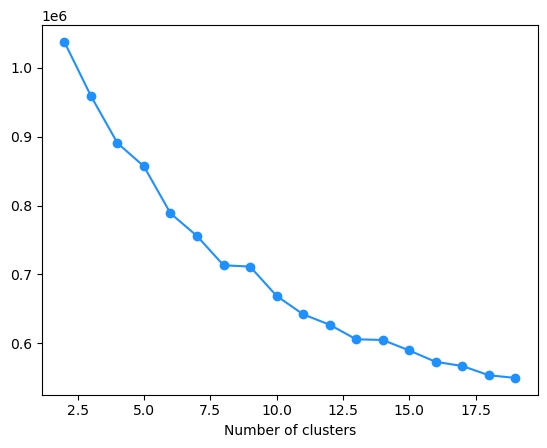

We see after we'll have 10 - 11 clusters in K-Means.


In [54]:
# KMeans

from sklearn.cluster import KMeans

ssd = []
range_n_clusters = list(range(2, 20))
for num_clusters in range_n_clusters:
    kmeans = KMeans(n_clusters=num_clusters, max_iter=1000)
    kmeans.fit(X_pca_final)
    
    ssd.append(kmeans.inertia_)

plt.xlabel('Number of clusters')
plt.plot(range_n_clusters, ssd, marker='o', color='dodgerblue')
plt.show()

print("We see after we'll have 10 - 11 clusters in K-Means.")

In [55]:
# Silhouette score - KMeans
from sklearn.metrics import silhouette_score

range_n_clusters = range(2, 11)
for num_clusters in range_n_clusters:
    kmeans = KMeans(n_clusters=num_clusters, max_iter=1000)
    kmeans.fit(X_pca_final)
    cluster_labels = kmeans.labels_

    silhouette_avg = silhouette_score(X_pca_final, cluster_labels)
    print("n_clusters={0}: silhouette score:\n{1}\n".format(num_clusters, silhouette_avg))

n_clusters=2: silhouette score:
0.12154613877740097

n_clusters=3: silhouette score:
0.10407281661241302

n_clusters=4: silhouette score:
0.12075179146621445

n_clusters=5: silhouette score:
0.12052243720844835

n_clusters=6: silhouette score:
0.10424371516544433

n_clusters=7: silhouette score:
0.10891733226863044

n_clusters=8: silhouette score:
0.09580842638575483

n_clusters=9: silhouette score:
0.09390889619033461

n_clusters=10: silhouette score:
0.09459965102766112



In [56]:
# KMeans
kmeans = KMeans(n_clusters=10, max_iter=1000, random_state=42)
kmeans.fit(X_pca_final)

# Adding a column with information about which cluster it is in (K-Means).
data['k_means_cluster'] = kmeans.labels_
data.head()

loan_amnt  term  int_rate  installment  sub_grade  emp_length  \
0        164     0        78         4161          6           1   
1         65     1       221          789         13          10   
2         61     0       239         1541         14           1   
3        359     0       160         9677         10           1   
4         85     1       135         1036          9           0   

   home_ownership  annual_inc  verification_status  loan_status  purpose  \
0               4         416                    2            1        1   
1               4         740                    1            0        0   
2               4          75                    0            1       11   
3               4        2106                    1            1        9   
4               4        3929                    1            1        9   

   addr_state   dti  delinq_2yrs  fico_range_low  inq_last_6mths  open_acc  \
0           3  2717            0              25               1         2   
1          10    99            0              26               5         2   
2          14   871            0              25               2         1   
3           4  1999            0              16               1         9   
4          36  1793            0              17               0        14   

   pub_rec  revol_bal  revol_util  total_acc  total_rec_late_fee  \
0        0      11564         930          8                   0   
1        0       1575         122          3                   0   
2        0       2746        1080          9                   0   
3        0       5135         251         36                1097   
4        0      18054         619         37                   0   

   collection_recovery_fee  acc_now_delinq  delinq_amnt  pub_rec_bankruptcies  \
0                        0               0            0                     0   
1                      172               0            0                     0   
2                        0               0            0                     0   
3                        0               0            0                     0   
4                        0               0            0                     0   

   tax_liens  debt_settlement_flag  credit_years  income_range  loan_range  \
0          0                     0            32             6           0   
1          0                     0            16             6           0   
2          0                     0            14             0           0   
3          0                     0            19            17           5   
4          0                     0            21            28           0   

   fico_score  k_means_cluster  
0           1                4  
1           2                4  
2           1                4  
3           1                2  
4           1                2

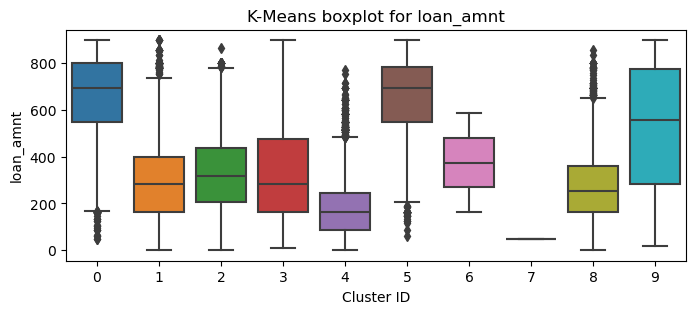

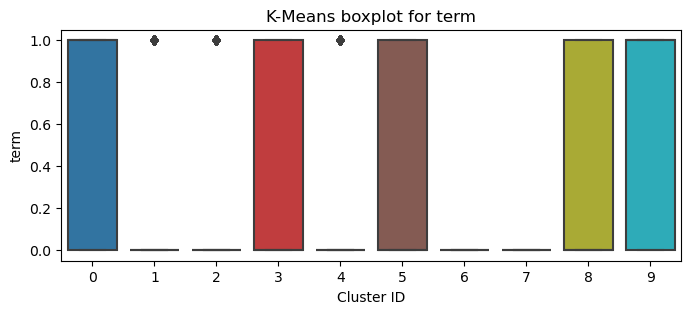

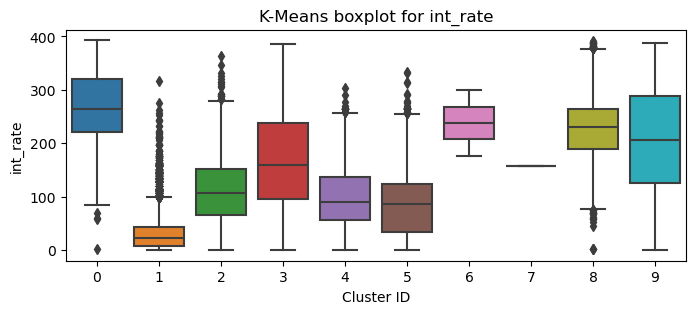

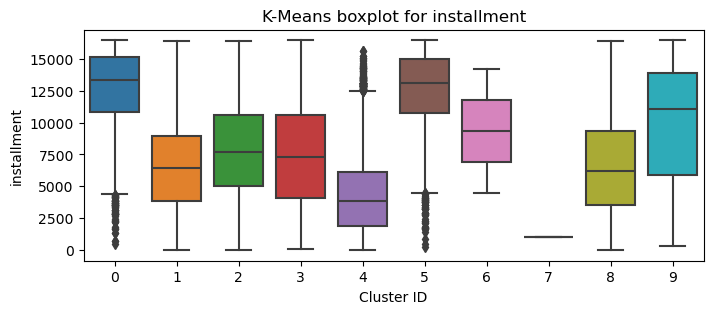

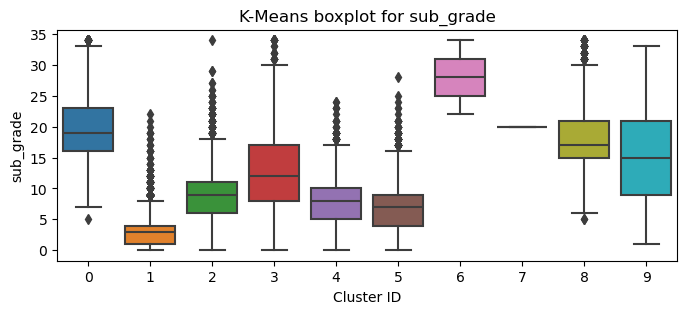

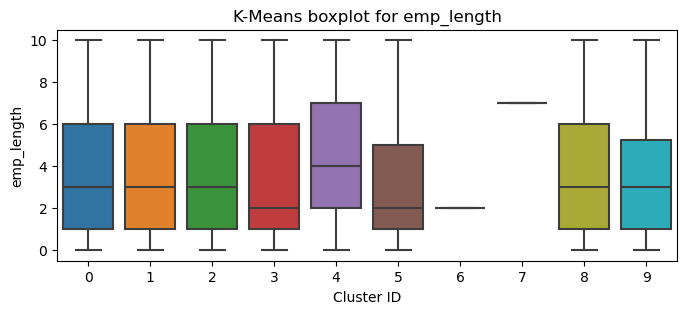

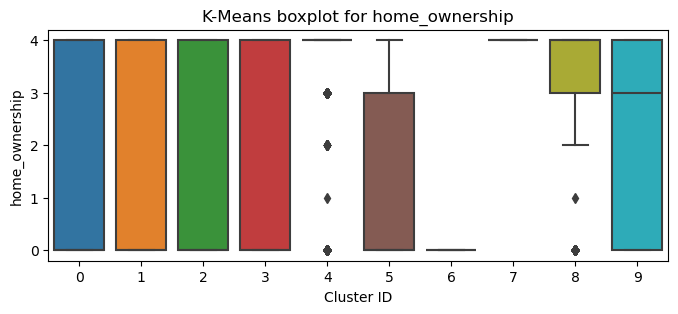

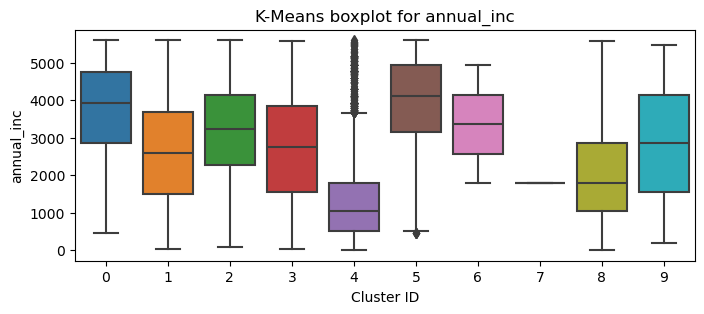

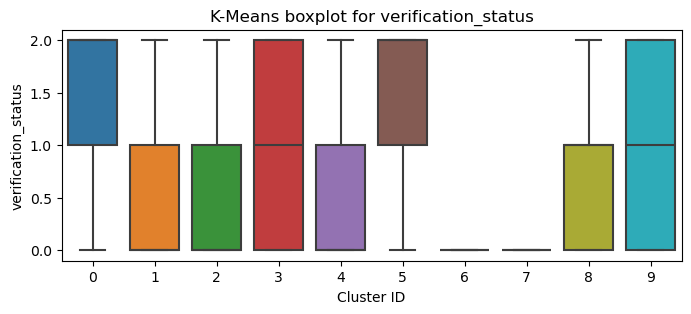

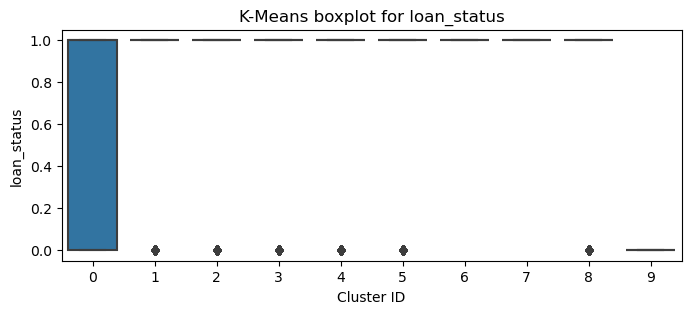

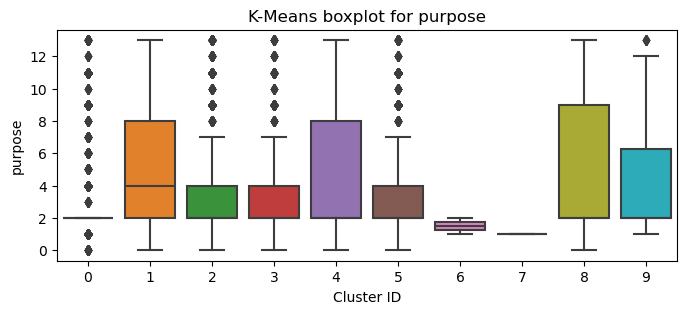

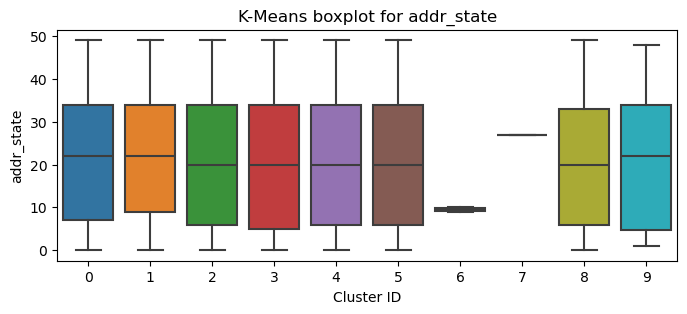

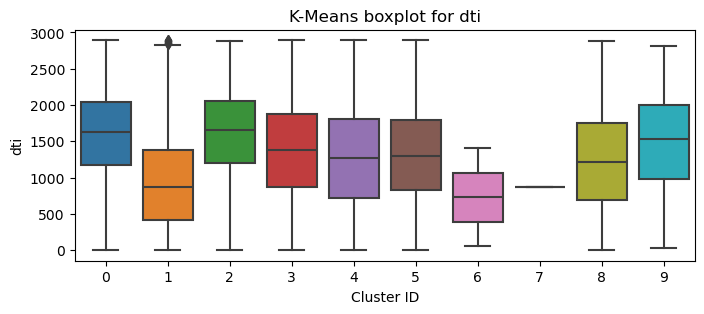

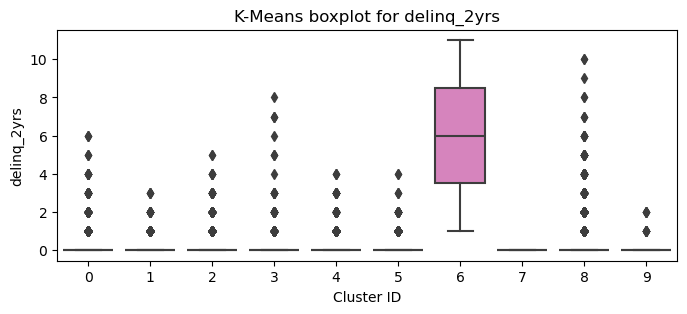

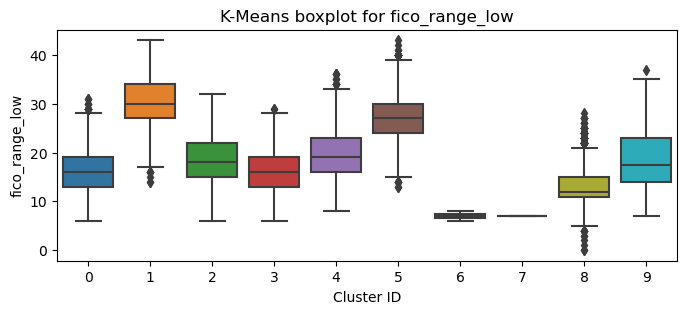

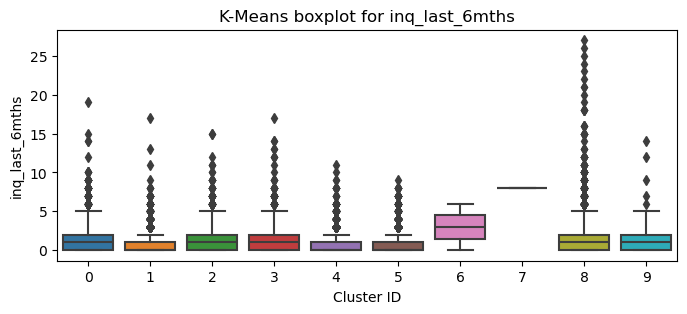

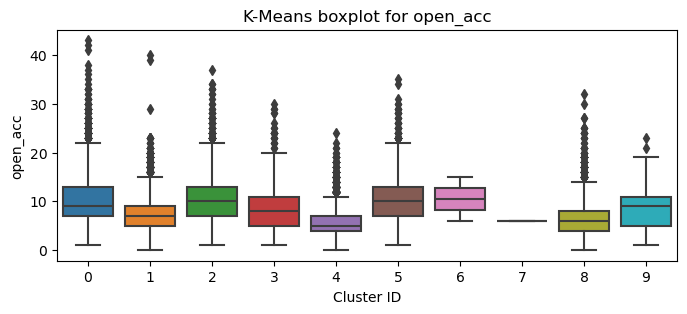

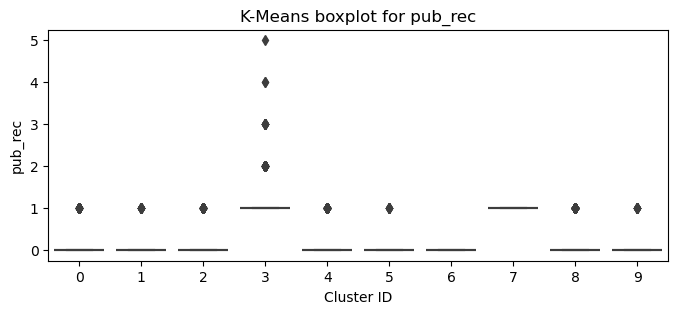

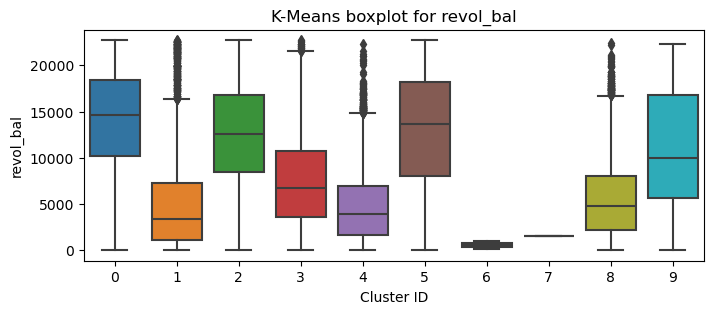

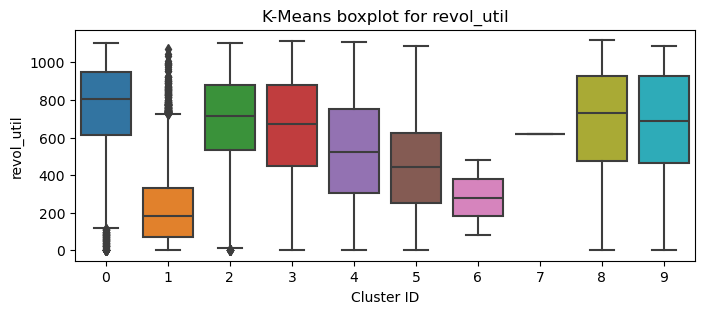

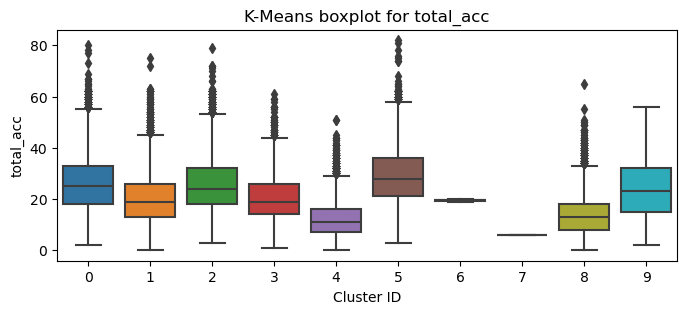

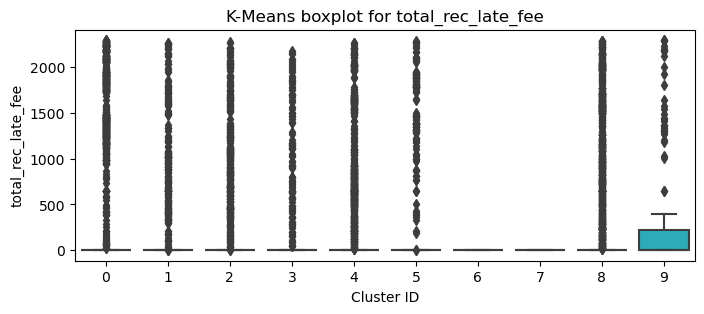

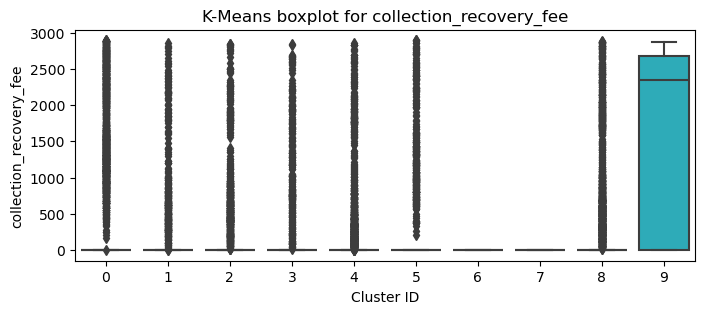

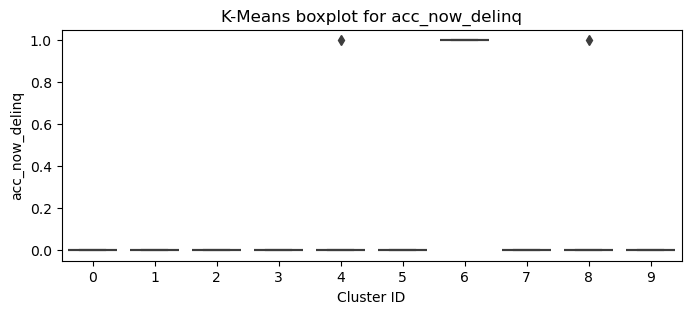

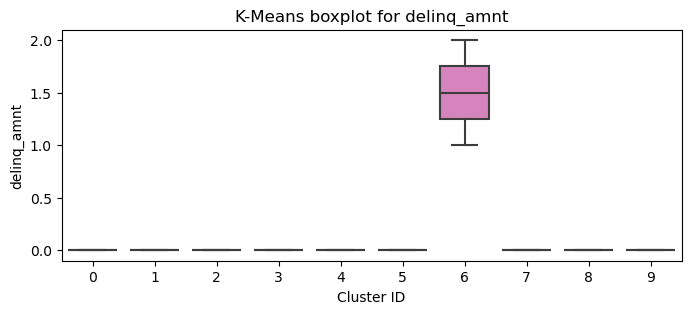

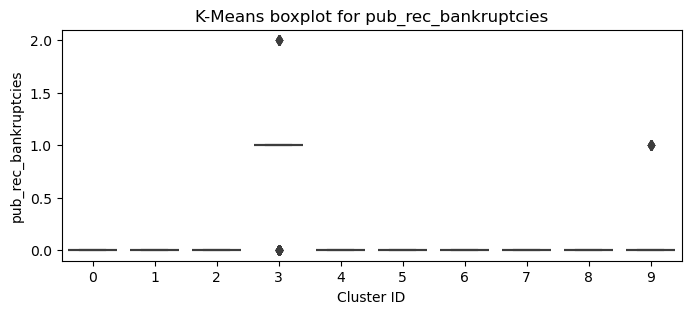

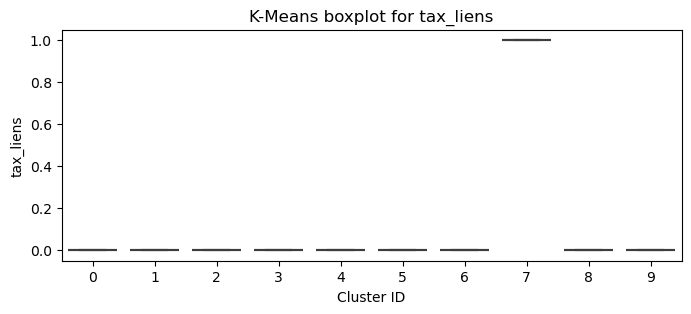

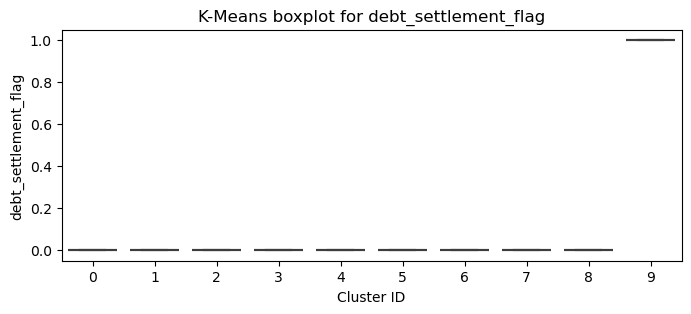

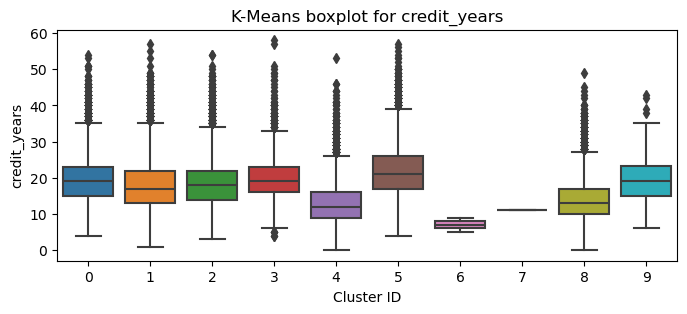

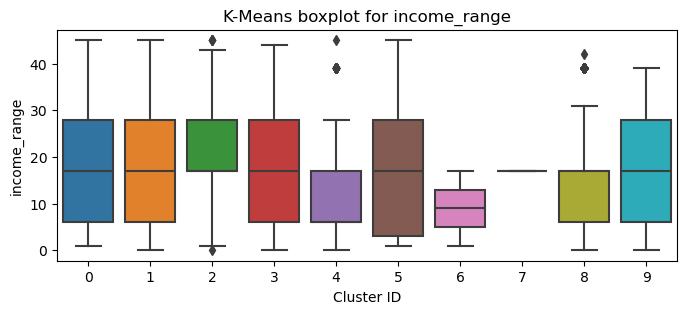

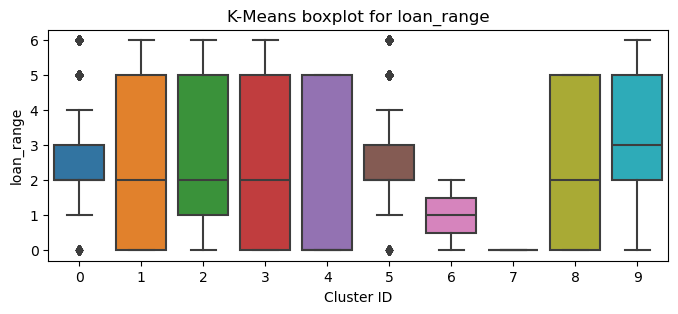

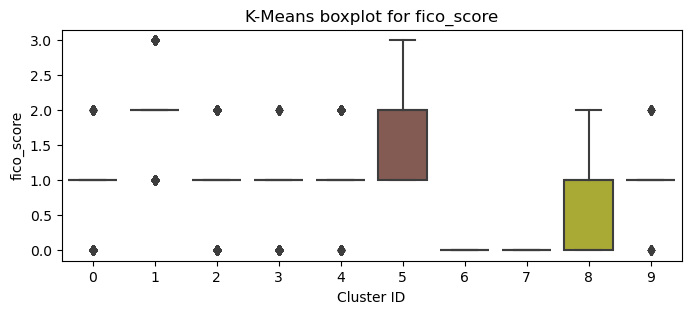

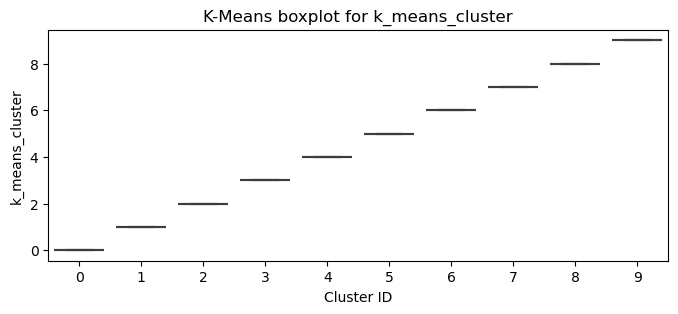

In [57]:
# Visualization of features in clusters (K-Means).
def boxplot_km(data, y_columns, **kwargs):
    cluster_id = kwargs.get('cluster_id_km', 'k_means_cluster')
    figsize = kwargs.get('figsize', (8, 3))
    dpi = kwargs.get('dpi', 100)
    
    for y_column in y_columns:
        plt.figure(figsize=figsize, dpi=dpi)
        
        sns.boxplot(x=cluster_id, y=y_column, data=data)
        
        plt.title(f'K-Means boxplot for {y_column}')
        plt.xlabel('Cluster ID')
        plt.ylabel(y_column)
        plt.show()

y_columns_to_plot = data.columns
boxplot_km(data, y_columns_to_plot)

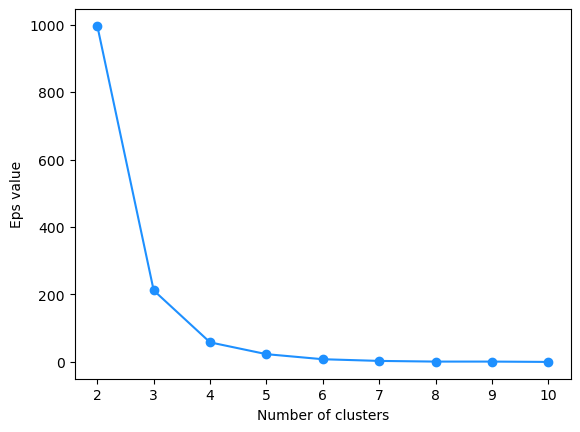

In [58]:
# DBSCAN

from sklearn.cluster import DBSCAN

num_clusters_list = []
range_n_clusters = range(2, 11) 
eps_value = 1 

for num_clusters in range_n_clusters:
    dbscan = DBSCAN(eps=eps_value, min_samples=num_clusters)
    dbscan.fit(X_pca_final)
    
    num_clusters_detected = len(np.unique(dbscan.labels_)) - 1 
    num_clusters_list.append(num_clusters_detected)

plt.xlabel('Number of clusters')
plt.ylabel('Eps value')
plt.plot(range_n_clusters, num_clusters_list, marker='o', color='dodgerblue')
plt.show()

# We see it should be 4 - 5 clusters.

In [59]:
# Silhouette score for DBSCAN.

from sklearn.metrics import silhouette_score

labels = dbscan.labels_

if len(np.unique(labels)) > 1:
    silhouette_avg = silhouette_score(X_pca_final, labels)
    print("Silhouette Score:", silhouette_avg)
else:
    print("We have only 1 cluster:", silhouette_avg)

# For one cluster we do not need create new column for data or show plots like with K-Means.

We have only 1 cluster: 0.09459965102766112


In [60]:
data.columns

Index(['loan_amnt', 'term', 'int_rate', 'installment', 'sub_grade',
       'emp_length', 'home_ownership', 'annual_inc', 'verification_status',
       'loan_status', 'purpose', 'addr_state', 'dti', 'delinq_2yrs',
       'fico_range_low', 'inq_last_6mths', 'open_acc', 'pub_rec', 'revol_bal',
       'revol_util', 'total_acc', 'total_rec_late_fee',
       'collection_recovery_fee', 'acc_now_delinq', 'delinq_amnt',
       'pub_rec_bankruptcies', 'tax_liens', 'debt_settlement_flag',
       'credit_years', 'income_range', 'loan_range', 'fico_score',
       'k_means_cluster'],
      dtype='object')

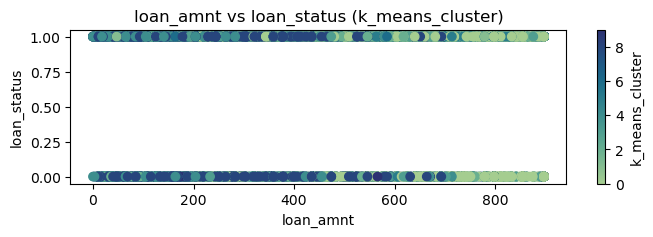

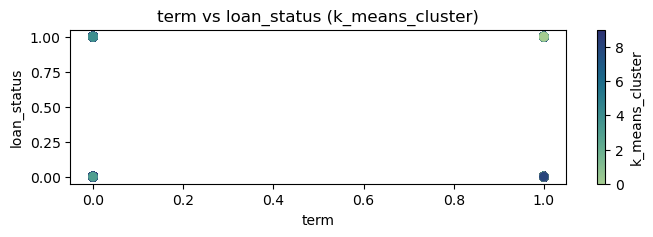

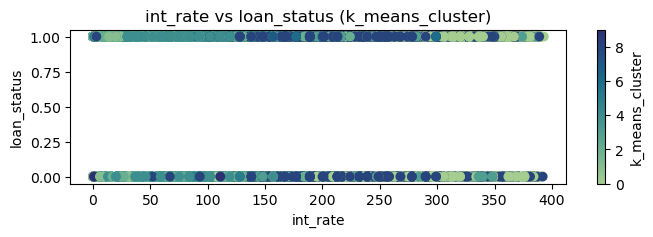

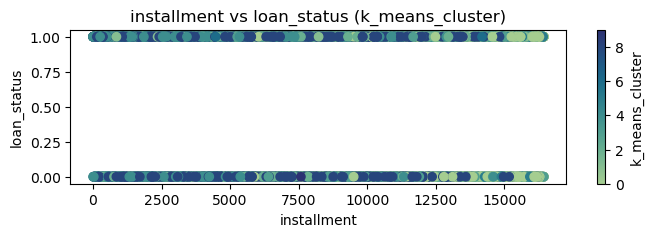

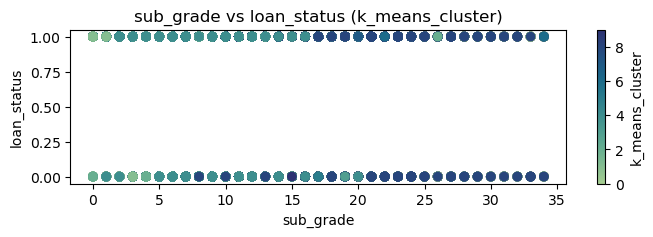

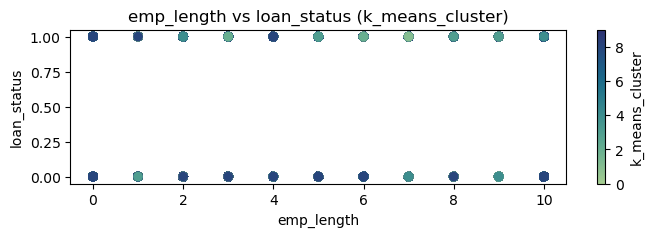

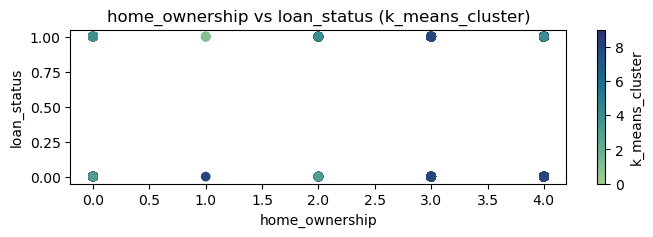

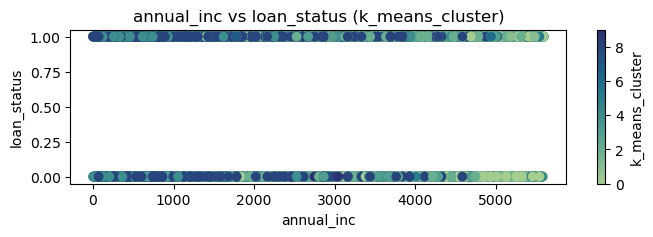

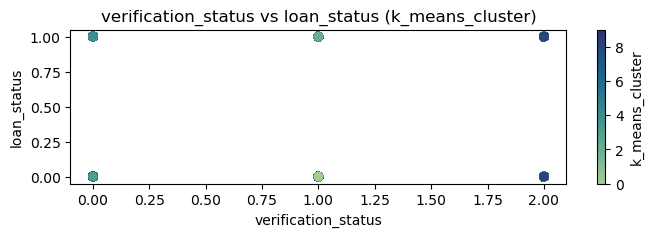

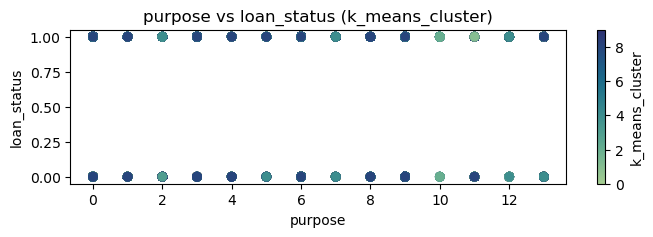

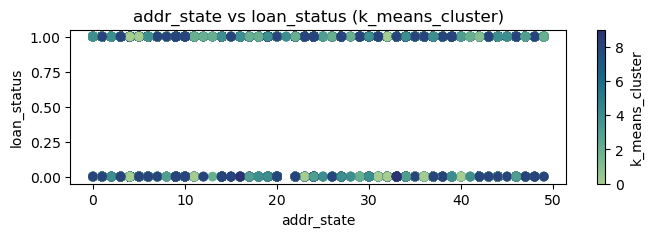

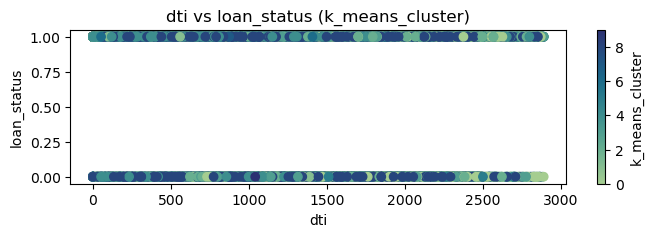

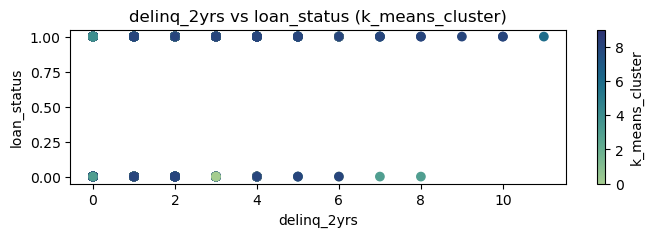

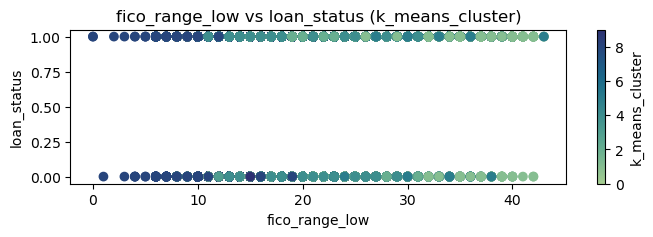

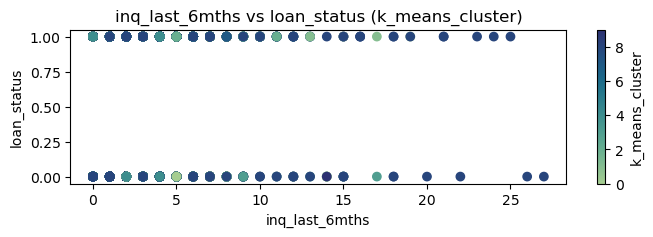

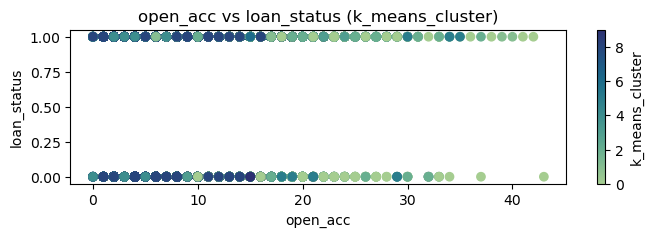

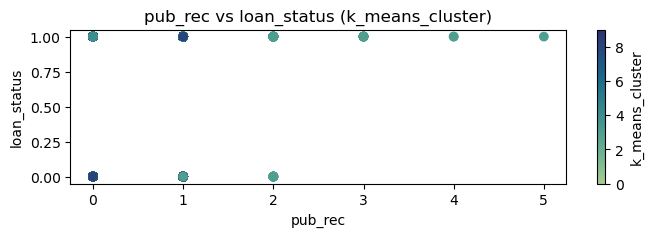

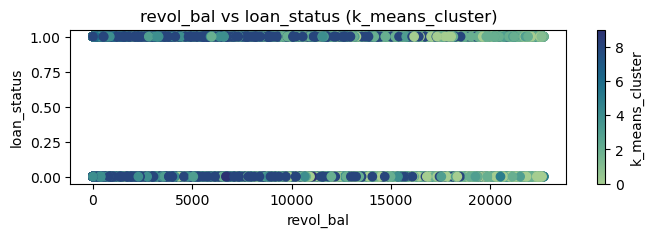

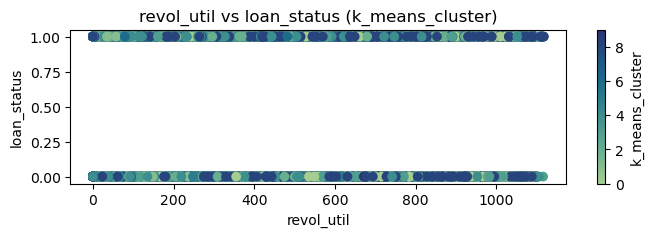

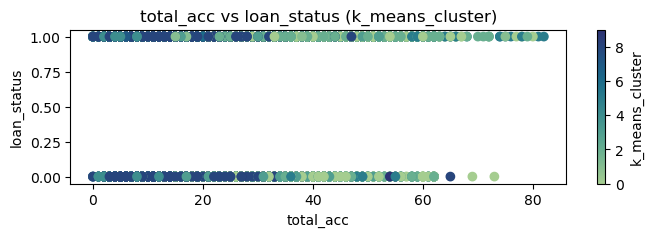

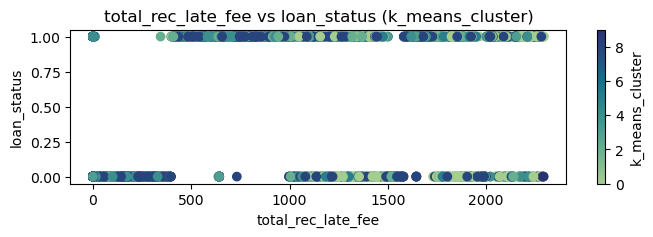

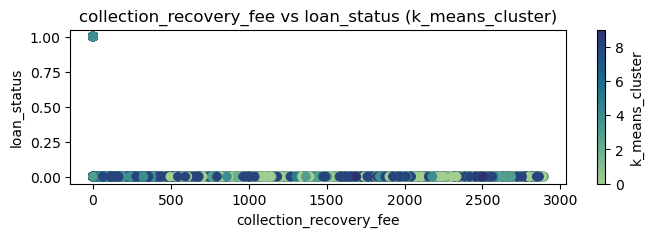

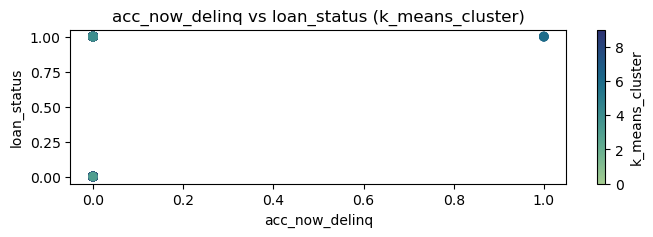

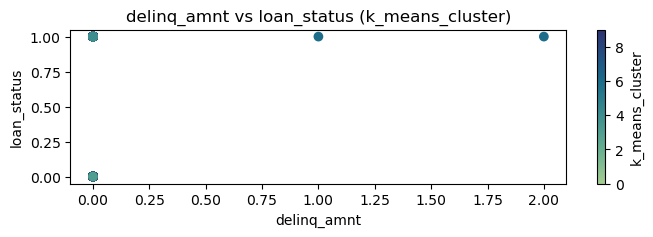

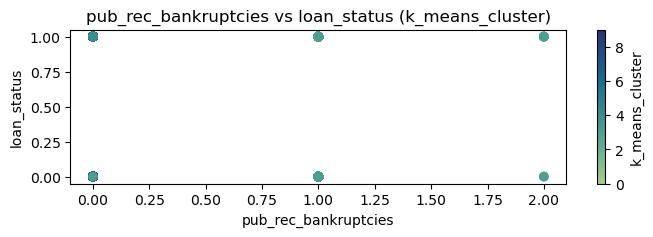

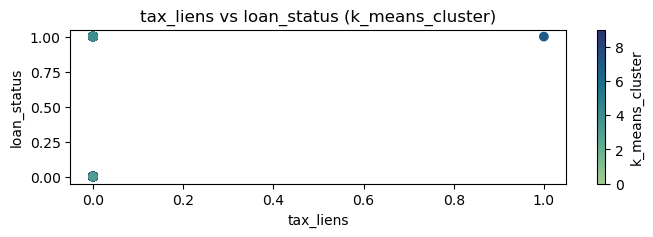

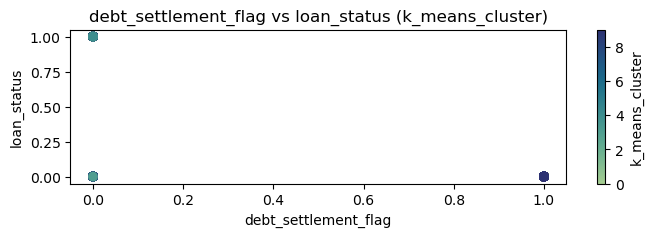

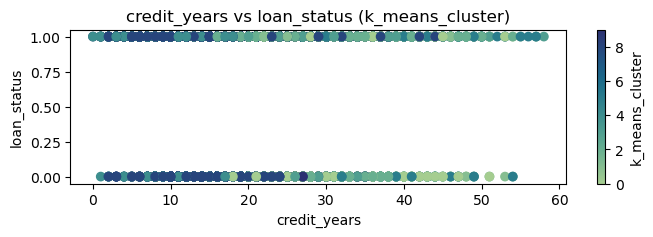

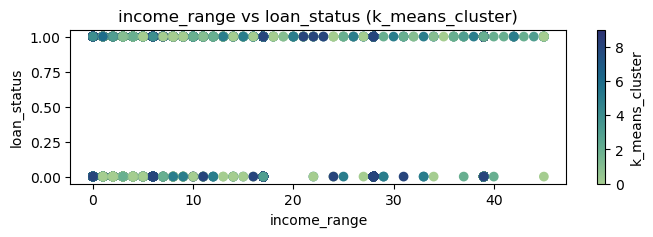

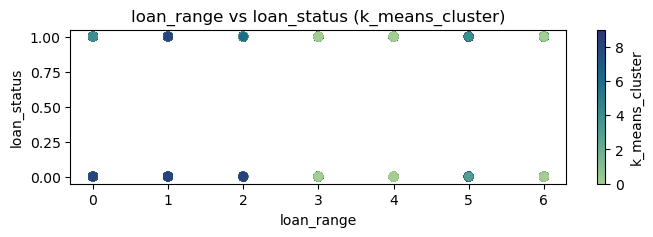

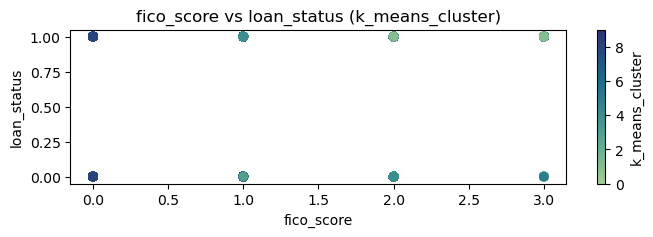

In [61]:
# K-Means Clusters for all variables from data.

columns_to_plot = list(data.columns)

for column in columns_to_plot:
    if column not in ['loan_status', 'k_means_cluster']:
        plt.figure(figsize=(8, 2))
        
        plt.scatter(data[column], data['loan_status'], c=data['k_means_cluster'], cmap='crest')
        
        plt.title(f'{column} vs loan_status (k_means_cluster)')
        plt.xlabel(column)
        plt.ylabel('loan_status')
        
        plt.colorbar(label='k_means_cluster')
        plt.show()

In [62]:
# Chi2 test checking whether there is a difference between clusters that affects loan repayment.

from scipy.stats import chi2_contingency

cross_tab = pd.crosstab(data['k_means_cluster'], data['loan_status'])

chi2, p_value, _, _ = chi2_contingency(cross_tab)

print(f"Chi-Squared: {chi2}")
print(f"P-value: {p_value}")

alpha = 0.05

if p_value < alpha:
    print("We reject the null hypothesis of no differences between clusters.")
else:
    print("There is insufficient evidence to reject the null hypothesis of no differences between clusters.")

# The established significance level is 0.05, we can modify it.

Chi-Squared: 2585.73623661142
P-value: 0.0
We reject the null hypothesis of no differences between clusters.


In [63]:
# PCA components.
X_pca_final_df = pd.DataFrame(X_pca_final, columns=['PC1','PC2', 'PC3', 'PC4', 'PC5', 
                                                    'PC6', 'PC7', 'PC8', 'PC9', 'PC10', 
                                                    'PC11', 'PC12', 'PC13', 'PC14', 'PC15',
                                                    'PC16', 'PC17', 'PC18', 'PC19'])

# PCA components with clusters.
X_pca_final_df['k_means_cluster'] = kmeans.labels_
X_pca_final_df.head()

PC1       PC2       PC3       PC4       PC5       PC6       PC7  \
0 -0.997764 -0.884878  0.292419 -1.295813 -0.581965 -2.023976  1.626931   
1 -2.504048 -1.931894 -1.582654  1.443835  0.103797  1.181974  0.635101   
2 -2.046591 -3.395985 -0.586939 -0.141194 -0.125868  0.381773  0.213156   
3  0.237465 -0.146362 -0.142124 -0.229137  0.117680  1.122580  0.813415   
4  0.619492  0.254954  1.484404 -1.496250  0.010063  1.151037  0.355264   

        PC8       PC9      PC10      PC11      PC12      PC13      PC14  \
0  0.628564 -2.287154  0.581960  0.679234 -0.506851  0.991870  0.196006   
1  1.579451  0.272347 -1.378122 -0.388714 -1.499753  0.152512  0.075557   
2  0.217030 -1.509863 -0.533498  0.056283  0.174066  1.207854 -1.083864   
3 -1.085134  0.965361  1.589435  0.522054 -0.885858  2.373197 -0.777639   
4  0.890860 -1.988461 -1.214977 -0.409950  0.708397 -0.131553  0.161509   

       PC15      PC16      PC17      PC18      PC19  k_means_cluster  
0  0.353170 -0.109205 -0.245428  0.069921  0.025213                4  
1 -2.499961  0.701598 -1.051686  0.368740 -0.688493                4  
2  0.575774 -1.432752 -0.023581  0.393676 -0.867206                4  
3  1.407057  0.854200  1.614629 -1.305508 -0.600566                2  
4  1.607095  0.653128  1.386095 -0.227283 -0.824584                2

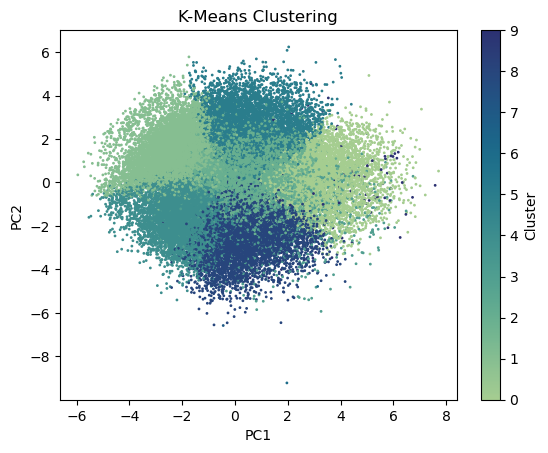

In [64]:
# Figures each showing a scatter plot of the first two principal components (PC1 and PC2).

plt.scatter(X_pca_final_df['PC1'], X_pca_final_df['PC2'], c=X_pca_final_df['k_means_cluster'], cmap='crest', s=1)
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.title('K-Means Clustering')
plt.colorbar(label='Cluster')
plt.show()

In [65]:
print('K-Means - 10, but visible 6.\n'
      'DBSCAN - 1 cluster.\n'
      'Before testing other clustering method I had too:\n'
      '    Hierarchical - 4 clusters,\n' 
      '    Agglomerative - 6 clusters,\n' 
      '    Mean shift - 5 clusters')

K-Means - 10, but visible 6.
DBSCAN - 1 cluster.
Before testing other clustering method I had too:
    Hierarchical - 4 clusters,
    Agglomerative - 6 clusters,
    Mean shift - 5 clusters


##### Train 5 different models, using a different algorithm for each, and then compare their performance, using the AUROC score as the model quality metric.

In [66]:
data.columns

Index(['loan_amnt', 'term', 'int_rate', 'installment', 'sub_grade',
       'emp_length', 'home_ownership', 'annual_inc', 'verification_status',
       'loan_status', 'purpose', 'addr_state', 'dti', 'delinq_2yrs',
       'fico_range_low', 'inq_last_6mths', 'open_acc', 'pub_rec', 'revol_bal',
       'revol_util', 'total_acc', 'total_rec_late_fee',
       'collection_recovery_fee', 'acc_now_delinq', 'delinq_amnt',
       'pub_rec_bankruptcies', 'tax_liens', 'debt_settlement_flag',
       'credit_years', 'income_range', 'loan_range', 'fico_score',
       'k_means_cluster'],
      dtype='object')

In [67]:
# Checking unique 'loan_status' values and counting their occurrence.
# Before clustering I encoded data.

counts_before_oversampling = data['loan_status'].value_counts()
print(counts_before_oversampling)

X = data.drop(
    [
        'loan_status', 
        'k_means_cluster'
        ], axis=1)
y = data['loan_status']

# print('X shape:', X.shape)
# print('y shape:', y.shape)

loan_status
1    36076
0     6427
Name: count, dtype: int64


AUROC Score: 0.9136909638616324


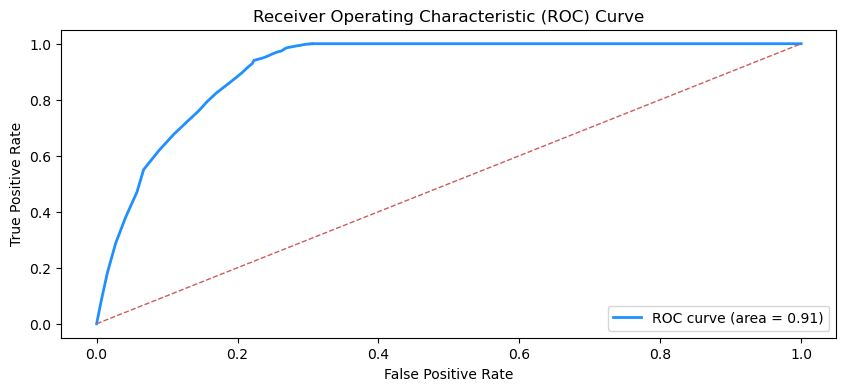

Confusion Matrix:
[[ 869  390]
 [   0 7242]]

True Negatives: 869
False Positives: 390
False Negatives: 0
True Positives: 7242 

Classification Report:
               precision    recall  f1-score   support

           0       1.00      0.69      0.82      1259
           1       0.95      1.00      0.97      7242

    accuracy                           0.95      8501
   macro avg       0.97      0.85      0.90      8501
weighted avg       0.96      0.95      0.95      8501



In [68]:
# RandomForestClassifier

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import roc_auc_score, roc_curve, confusion_matrix
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report

# Apply LabelEncoder.
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)

# Split data into train and test sets.
X_train, X_test, y_train, y_test = train_test_split(X, y_encoded, test_size=0.2, random_state=42)

# Scale the data.
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Train the model.
rf_model = RandomForestClassifier(random_state=42)
rf_model.fit(X_train_scaled, y_train)

# Predict probabilities for ROC curve.
y_pred_proba_rf = rf_model.predict_proba(X_test_scaled)[:, 1]

# AUROC score.
auroc_rf = roc_auc_score(y_test, y_pred_proba_rf)
print("AUROC Score:", auroc_rf)

# ROC curve.
fpr, tpr, _ = roc_curve(y_test, y_pred_proba_rf)

plt.figure(figsize=(10, 4))
plt.plot(fpr, tpr, color='dodgerblue', lw=2, label='ROC curve (area = %0.2f)' % auroc_rf)
plt.plot([0, 1], [0, 1], color='indianred', lw=1, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()

# Confusion matrix.
y_pred = rf_model.predict(X_test_scaled)
conf_matric_rf = confusion_matrix(y_test, y_pred)

print("Confusion Matrix:")
print(conf_matric_rf)
print('')
tn, fp, fn, tp = conf_matric_rf.ravel()
print("True Negatives:", tn)
print("False Positives:", fp)
print("False Negatives:", fn)
print("True Positives:", tp, '\n')

report_rf = classification_report(y_test, y_pred)
print("Classification Report:\n", report_rf)

AUROC Score for SVC: 0.8819665489393242


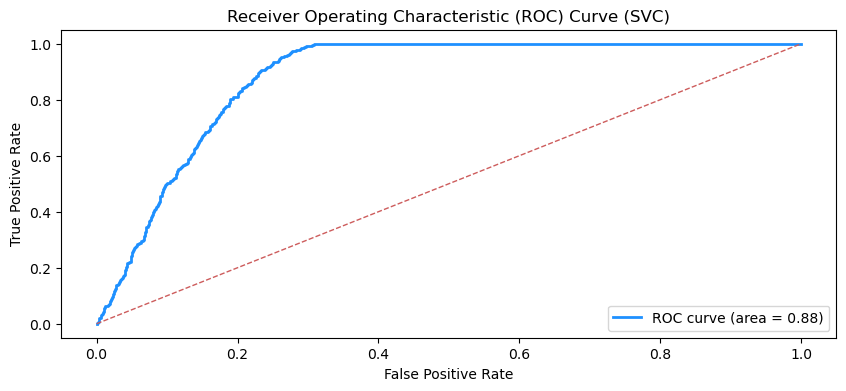

Confusion Matrix for SVC:
[[ 803  456]
 [   0 7242]]

True Negatives: 803
False Positives: 456
False Negatives: 0
True Positives: 7242 

Classification Report for SVC:
               precision    recall  f1-score   support

           0       1.00      0.64      0.78      1259
           1       0.94      1.00      0.97      7242

    accuracy                           0.95      8501
   macro avg       0.97      0.82      0.87      8501
weighted avg       0.95      0.95      0.94      8501



In [69]:
# SVC

from sklearn.svm import SVC

# Apply LabelEncoder.
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)

# Split data into train and test sets.
X_train, X_test, y_train, y_test = train_test_split(X, y_encoded, test_size=0.2, random_state=42)

# Scale the data.
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Train the SVC model.
svc_model = SVC(probability=True, random_state=42)
svc_model.fit(X_train_scaled, y_train)

# Predict probabilities for ROC curve.
y_pred_proba_svc = svc_model.predict_proba(X_test_scaled)[:, 1]

# AUROC score for SVC.
auroc_svc = roc_auc_score(y_test, y_pred_proba_svc)
print("AUROC Score for SVC:", auroc_svc)

# ROC curve for SVC.
fpr_svc, tpr_svc, _ = roc_curve(y_test, y_pred_proba_svc)

plt.figure(figsize=(10, 4))
plt.plot(fpr_svc, tpr_svc, color='dodgerblue', lw=2, label='ROC curve (area = %0.2f)' % auroc_svc)
plt.plot([0, 1], [0, 1], color='indianred', lw=1, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve (SVC)')
plt.legend(loc="lower right")
plt.show()

# Confusion matrix for SVC.
y_pred_svc = svc_model.predict(X_test_scaled)
conf_matrix_svc = confusion_matrix(y_test, y_pred_svc)

print("Confusion Matrix for SVC:")
print(conf_matrix_svc)
tn_svc, fp_svc, fn_svc, tp_svc = conf_matrix_svc.ravel()
print('')
print("True Negatives:", tn_svc)
print("False Positives:", fp_svc)
print("False Negatives:", fn_svc)
print("True Positives:", tp_svc, '\n')

# Classification report for SVC.
report_svc = classification_report(y_test, y_pred_svc)
print("Classification Report for SVC:\n", report_svc)

AUROC Score for Logistic Regression: 0.9181048069475584


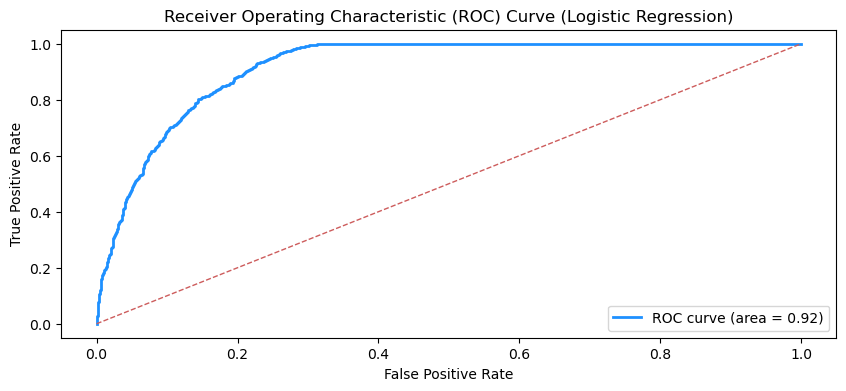

Confusion Matrix for Logistic Regression:
[[ 849  410]
 [   2 7240]]
True Negatives: 849
False Positives: 410
False Negatives: 2
True Positives: 7240 

Classification Report for Logistic Regression:
               precision    recall  f1-score   support

           0       1.00      0.67      0.80      1259
           1       0.95      1.00      0.97      7242

    accuracy                           0.95      8501
   macro avg       0.97      0.84      0.89      8501
weighted avg       0.95      0.95      0.95      8501



In [70]:
# LogisticRegression

from sklearn.linear_model import LogisticRegression

# Apply LabelEncoder.
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)

# Split data into train and test sets.
X_train, X_test, y_train, y_test = train_test_split(X, y_encoded, test_size=0.2, random_state=42)

# Scale the data.
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Train the Logistic Regression model.
lr_model = LogisticRegression(random_state=42)
lr_model.fit(X_train_scaled, y_train)

# Predict probabilities for ROC curve.
y_pred_proba_lr = lr_model.predict_proba(X_test_scaled)[:, 1]

# AUROC score for Logistic Regression.
auroc_lr = roc_auc_score(y_test, y_pred_proba_lr)
print("AUROC Score for Logistic Regression:", auroc_lr)

# ROC curve for Logistic Regression.
fpr_lr, tpr_lr, _ = roc_curve(y_test, y_pred_proba_lr)

plt.figure(figsize=(10, 4))
plt.plot(fpr_lr, tpr_lr, color='dodgerblue', lw=2, label='ROC curve (area = %0.2f)' % auroc_lr)
plt.plot([0, 1], [0, 1], color='indianred', lw=1, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve (Logistic Regression)')
plt.legend(loc="lower right")
plt.show()

# Confusion matrix for Logistic Regression.
y_pred_lr = lr_model.predict(X_test_scaled)
conf_matrix_logreg = confusion_matrix(y_test, y_pred_lr)

print("Confusion Matrix for Logistic Regression:")
print(conf_matrix_logreg)
tn_lr, fp_lr, fn_lr, tp_lr = conf_matrix_logreg.ravel()
print("True Negatives:", tn_lr)
print("False Positives:", fp_lr)
print("False Negatives:", fn_lr)
print("True Positives:", tp_lr, '\n')

# Classification report for Logistic Regression.
report_lr = classification_report(y_test, y_pred_lr)
print("Classification Report for Logistic Regression:\n", report_lr)

AUROC Score for KNN: 0.7806088896756389


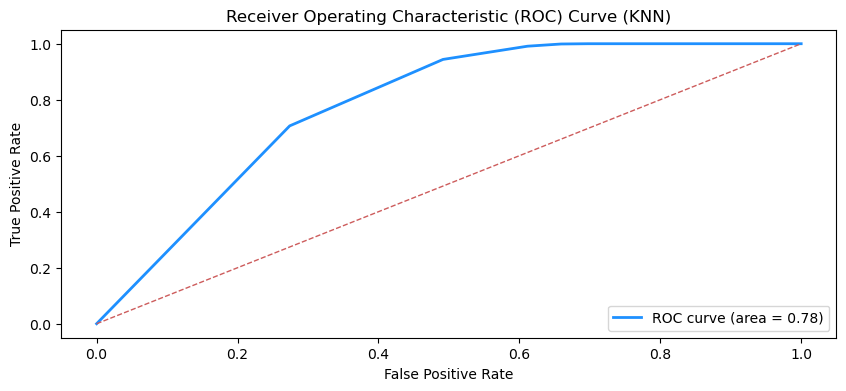

Confusion Matrix for KNN:
[[ 489  770]
 [  64 7178]]
True Negatives: 489
False Positives: 770
False Negatives: 64
True Positives: 7178 

Classification Report for KNN:
               precision    recall  f1-score   support

           0       0.88      0.39      0.54      1259
           1       0.90      0.99      0.95      7242

    accuracy                           0.90      8501
   macro avg       0.89      0.69      0.74      8501
weighted avg       0.90      0.90      0.89      8501



In [71]:
# KNeighborsClassifier

from sklearn.neighbors import KNeighborsClassifier

# Apply LabelEncoder.
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)

# Split data into train and test sets.
X_train, X_test, y_train, y_test = train_test_split(X, y_encoded, test_size=0.2, random_state=42)

# Scale the data.
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Train the KNN model.
knn_model = KNeighborsClassifier()
knn_model.fit(X_train_scaled, y_train)

# Predict probabilities for ROC curve.
y_pred_proba_knn = knn_model.predict_proba(X_test_scaled)[:, 1]

# AUROC score for KNN.
auroc_knn = roc_auc_score(y_test, y_pred_proba_knn)
print("AUROC Score for KNN:", auroc_knn)

# ROC curve for KNN.
fpr_knn, tpr_knn, _ = roc_curve(y_test, y_pred_proba_knn)

plt.figure(figsize=(10, 4))
plt.plot(fpr_knn, tpr_knn, color='dodgerblue', lw=2, label='ROC curve (area = %0.2f)' % auroc_knn)
plt.plot([0, 1], [0, 1], color='indianred', lw=1, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve (KNN)')
plt.legend(loc="lower right")
plt.show()

# Confusion matrix for KNN.
y_pred_knn = knn_model.predict(X_test_scaled)
conf_matrix_knn = confusion_matrix(y_test, y_pred_knn)

print("Confusion Matrix for KNN:")
print(conf_matrix_knn)
tn_knn, fp_knn, fn_knn, tp_knn = conf_matrix_knn.ravel()
print("True Negatives:", tn_knn)
print("False Positives:", fp_knn)
print("False Negatives:", fn_knn)
print("True Positives:", tp_knn, '\n')

# Classification report for KNN.
report_knn = classification_report(y_test, y_pred_knn)
print("Classification Report for KNN:\n", report_knn)


AUROC Score for Decision Tree: 0.8337317352071438


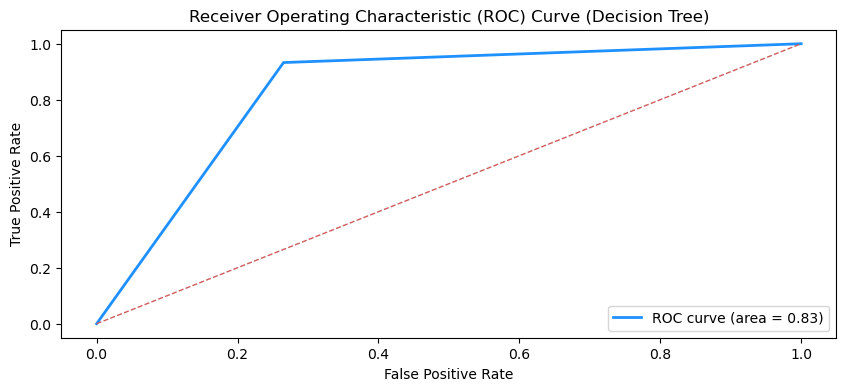

Confusion Matrix for Decision Tree:
[[ 925  334]
 [ 487 6755]]
True Negatives: 925
False Positives: 334
False Negatives: 487
True Positives: 6755 

Classification Report for Decision Tree:
               precision    recall  f1-score   support

           0       0.66      0.73      0.69      1259
           1       0.95      0.93      0.94      7242

    accuracy                           0.90      8501
   macro avg       0.80      0.83      0.82      8501
weighted avg       0.91      0.90      0.91      8501



In [72]:
# DecisionTreeClassifier

from sklearn.tree import DecisionTreeClassifier

# Apply LabelEncoder.
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)

# Split data into train and test sets.
X_train, X_test, y_train, y_test = train_test_split(X, y_encoded, test_size=0.2, random_state=42)

# Scale the data.
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Train the Decision Tree model.
dt_model = DecisionTreeClassifier(random_state=42)
dt_model.fit(X_train_scaled, y_train)

# Predict probabilities for ROC curve.
y_pred_proba_dt = dt_model.predict_proba(X_test_scaled)[:, 1]

# AUROC score for Decision Tree.
auroc_dt = roc_auc_score(y_test, y_pred_proba_dt)
print("AUROC Score for Decision Tree:", auroc_dt)

# ROC curve for Decision Tree.
fpr_dt, tpr_dt, _ = roc_curve(y_test, y_pred_proba_dt)

plt.figure(figsize=(10, 4))
plt.plot(fpr_dt, tpr_dt, color='dodgerblue', lw=2, label='ROC curve (area = %0.2f)' % auroc_dt)
plt.plot([0, 1], [0, 1], color='indianred', lw=1, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve (Decision Tree)')
plt.legend(loc="lower right")
plt.show()

# Confusion matrix for Decision Tree.
y_pred_dt = dt_model.predict(X_test_scaled)
conf_matrix_dt = confusion_matrix(y_test, y_pred_dt)

print("Confusion Matrix for Decision Tree:")
print(conf_matrix_dt)
tn_dt, fp_dt, fn_dt, tp_dt = conf_matrix_dt.ravel()
print("True Negatives:", tn_dt)
print("False Positives:", fp_dt)
print("False Negatives:", fn_dt)
print("True Positives:", tp_dt, '\n')

# Classification report for Decision Tree.
report_dt = classification_report(y_test, y_pred_dt)
print("Classification Report for Decision Tree:\n", report_dt)

In [73]:
# Results for AUROC
results_auroc = {
    'Model': ['RandomForestClassifier', 'SVC', 'LogisticRegression', 'KNN', 'DecisionTree'],
    'AUROC Score': [auroc_rf, auroc_svc, auroc_lr, auroc_knn, auroc_dt]
}
results_auroc = pd.DataFrame(results_auroc)

print(results_auroc)
print(60 * '#')
print("RandomForestClassifier:\n", report_rf)
print(60 * '#')
print("SVC:\n", report_svc)
print(60 * '#')
print("LogisticRegression:\n", report_lr)
print(60 * '#')
print("KNN:\n", report_knn)
print(60 * '#')
print("DecisionTree:\n", report_dt)
print(60 * '#')


                    Model  AUROC Score
0  RandomForestClassifier     0.913691
1                     SVC     0.881967
2      LogisticRegression     0.918105
3                     KNN     0.780609
4            DecisionTree     0.833732
############################################################
RandomForestClassifier:
               precision    recall  f1-score   support

           0       1.00      0.69      0.82      1259
           1       0.95      1.00      0.97      7242

    accuracy                           0.95      8501
   macro avg       0.97      0.85      0.90      8501
weighted avg       0.96      0.95      0.95      8501

############################################################
SVC:
               precision    recall  f1-score   support

           0       1.00      0.64      0.78      1259
           1       0.94      1.00      0.97      7242

    accuracy                           0.95      8501
   macro avg       0.97      0.82      0.87      8501
weighted avg  

##### Check the operation of previously used methods on compressed data using PCA, compare the results (AUROC score) with the models trained in the previous section.

In [74]:
from sklearn.decomposition import PCA

# Apply LabelEncoder.
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)

# Split data into train and test sets.
X_train, X_test, y_train, y_test = train_test_split(X, y_encoded, test_size=0.2, random_state=42)

# Scale the data.
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Initialize and adjust the PCA transformer on training data
pca = PCA(n_components=0.95, random_state=42)
X_train_pca = pca.fit_transform(X_train_scaled)
X_test_pca = pca.transform(X_test_scaled)

# Model RandomForestClassifier
model_rf_pca = RandomForestClassifier(random_state=42)
model_rf_pca.fit(X_train_pca, y_train)
y_pred_proba_rf_pca = model_rf_pca.predict_proba(X_test_pca)[:, 1]
auroc_rf_pca = roc_auc_score(y_test, y_pred_proba_rf_pca)
print("AUROC Score for RandomForestClassifier after PCA:", auroc_rf_pca)

# Model SVC
model_svc_pca = SVC(probability=True, random_state=42)
model_svc_pca.fit(X_train_pca, y_train)
y_pred_proba_svc_pca = model_svc_pca.predict_proba(X_test_pca)[:, 1]
auroc_svc_pca = roc_auc_score(y_test, y_pred_proba_svc_pca)
print("AUROC Score for SVC after PCA:", auroc_svc_pca)

# Model Logistic Regression
model_lr_pca = LogisticRegression(random_state=42)
model_lr_pca.fit(X_train_pca, y_train)
y_pred_proba_lr_pca = model_lr_pca.predict_proba(X_test_pca)[:, 1]
auroc_lr_pca = roc_auc_score(y_test, y_pred_proba_lr_pca)
print("AUROC Score for Logistic Regression after PCA:", auroc_lr_pca)

# Model KNN
model_knn_pca = KNeighborsClassifier()
model_knn_pca.fit(X_train_pca, y_train)
y_pred_proba_knn_pca = model_knn_pca.predict_proba(X_test_pca)[:, 1]
auroc_knn_pca = roc_auc_score(y_test, y_pred_proba_knn_pca)
print("AUROC Score for KNN after PCA:", auroc_knn_pca)

# Model Decision Tree
model_dt_pca = DecisionTreeClassifier(random_state=42)
model_dt_pca.fit(X_train_pca, y_train)
y_pred_proba_dt_pca = model_dt_pca.predict_proba(X_test_pca)[:, 1]
auroc_dt_pca = roc_auc_score(y_test, y_pred_proba_dt_pca)
print("AUROC Score for Decision Tree after PCA:", auroc_dt_pca)

AUROC Score for RandomForestClassifier after PCA: 0.8708428834622148
AUROC Score for SVC after PCA: 0.8756301768937224
AUROC Score for Logistic Regression after PCA: 0.9172460356682919
AUROC Score for KNN after PCA: 0.7764107813414775
AUROC Score for Decision Tree after PCA: 0.7444990928611429


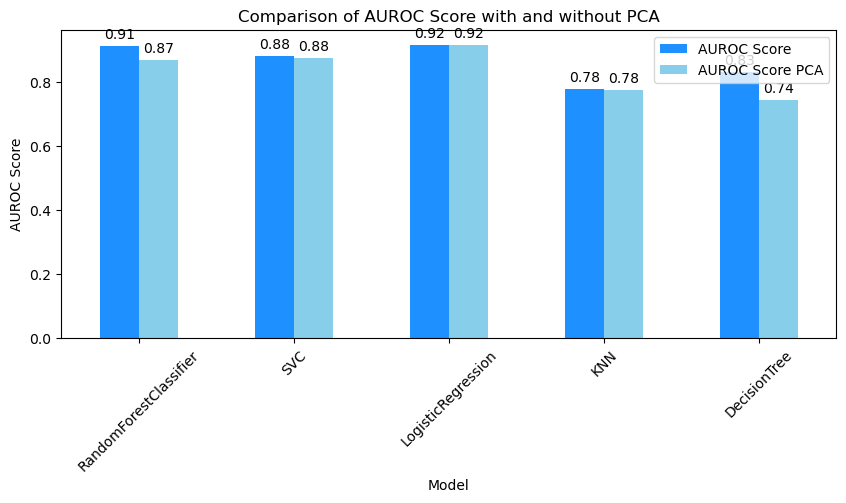

In [75]:
# Create dataframe for AUROC score PCA.
results_auroc_pca = {
    'Model': ['RandomForestClassifier', 'SVC', 'LogisticRegression', 'KNN', 'DecisionTree'],
    'AUROC Score': [auroc_rf_pca, auroc_svc_pca, auroc_lr_pca, auroc_knn_pca, auroc_dt_pca]
}

df_auroc = pd.DataFrame(results_auroc)
df_auroc_pca = pd.DataFrame(results_auroc_pca)

# Merge dataframes.
df_combined = pd.merge(df_auroc, df_auroc_pca, on='Model')

# Plot.
ax = df_combined.plot(kind='bar', x='Model', figsize=(10, 4), color=['dodgerblue', 'skyblue'])
plt.xlabel('Model')
plt.ylabel('AUROC Score')
plt.title('Comparison of AUROC Score with and without PCA')
plt.xticks(rotation=45)


for rect in ax.patches:
    height = rect.get_height()
    ax.annotate(f'{height:.2f}', xy=(rect.get_x() + rect.get_width() / 2, height),
                xytext=(0, 3), 
                textcoords="offset points",
                ha='center', va='bottom')

plt.legend(["AUROC Score", "AUROC Score PCA"])

plt.show()

##### Build the final model whose AUROC score will be >= 80%, remember to select important variables, cross-validate and tune model parameters, also think about balancing classes.

In [76]:
# Checking unique 'loan_status' values and counting their occurrence.

counts_before_oversampling = data['loan_status'].value_counts()
print(counts_before_oversampling)

print('\nWe have to make oversampling for Y.\n')

X = data.drop(
    [
        'loan_status', 
        'k_means_cluster'
        ], axis=1)
y = data['loan_status']

print('X shape:', X.shape)
print('y shape:', y.shape)

loan_status
1    36076
0     6427
Name: count, dtype: int64

We have to make oversampling for Y.

X shape: (42503, 31)
y shape: (42503,)


In [77]:
# Oversampling and class balance.

from sklearn.datasets import make_classification
from imblearn.over_sampling import SMOTE
import numpy as np

X = data.drop(
    [
        'loan_status',
        ], axis=1).values
y = data['loan_status'].values

# We need oversampling on training data.
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

X_synthetic, y_synthetic = make_classification(n_samples=42000, n_features=X_train.shape[1], n_classes=2, random_state=42)

# SMOTE.
smote = SMOTE(random_state=42)

# Oversampling.
X_resampled, y_resampled = smote.fit_resample(X_synthetic, y_synthetic)

counts = np.bincount(y_resampled)

print('X shape:', X.shape)
print('y shape:', y.shape, '\n')
print("X_resampled shape:", X_resampled.shape)
print("y_resampled shape:", y_resampled.shape, '\n')
print("y before resampling:", data['loan_status'].value_counts(), '\n')
print("y_resampled 0:", counts[0])
print("y_resampled 1:", counts[1])

X shape: (42503, 32)
y shape: (42503,) 

X_resampled shape: (42012, 32)
y_resampled shape: (42012,) 

y before resampling: loan_status
1    36076
0     6427
Name: count, dtype: int64 

y_resampled 0: 21006
y_resampled 1: 21006


AUROC Score: 0.9670774684789154


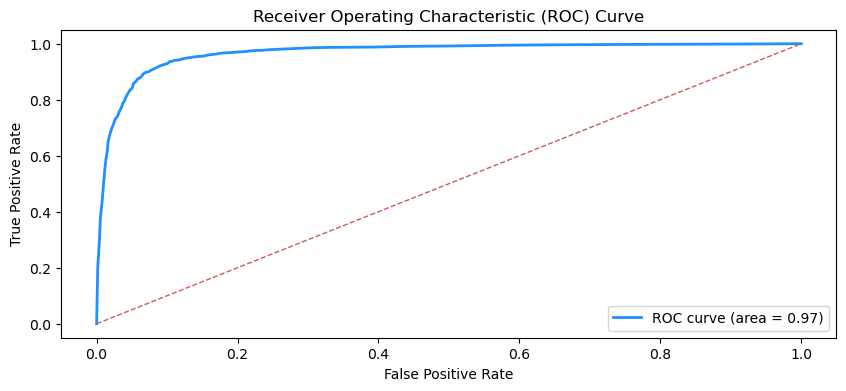

Confusion Matrix:
[[3799  391]
 [ 319 3894]]
True Negatives: 3799
False Positives: 391
False Negatives: 319
True Positives: 3894 

Classification Report:
               precision    recall  f1-score   support

           0       0.92      0.91      0.91      4190
           1       0.91      0.92      0.92      4213

    accuracy                           0.92      8403
   macro avg       0.92      0.92      0.92      8403
weighted avg       0.92      0.92      0.92      8403



In [78]:
# Final model. I use RandomForestClassifier in oversampled data.

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import roc_auc_score, roc_curve, confusion_matrix
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report

# Apply LabelEncoder.
label_encoder = LabelEncoder()
y_resampled_encoded = label_encoder.fit_transform(y_resampled)

# Split data into train and test sets.
X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled_encoded, test_size=0.2, random_state=42)

# Scale the data.
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Train the model.
final_model = RandomForestClassifier(random_state=42)
final_model.fit(X_train_scaled, y_train)

# Predict probabilities for ROC curve.
y_pred_proba_rf = final_model.predict_proba(X_test_scaled)[:, 1]

# AUROC score.
auroc_rf = roc_auc_score(y_test, y_pred_proba_rf)
print("AUROC Score:", auroc_rf)

# ROC curve.
fpr, tpr, _ = roc_curve(y_test, y_pred_proba_rf)

plt.figure(figsize=(10, 4))
plt.plot(fpr, tpr, color='dodgerblue', lw=2, label='ROC curve (area = %0.2f)' % auroc_rf)
plt.plot([0, 1], [0, 1], color='indianred', lw=1, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()

# Confusion matrix.
y_pred = final_model.predict(X_test_scaled)
conf_matric_rf = confusion_matrix(y_test, y_pred)

print("Confusion Matrix:")
print(conf_matric_rf)
tn, fp, fn, tp = conf_matric_rf.ravel()
print("True Negatives:", tn)
print("False Positives:", fp)
print("False Negatives:", fn)
print("True Positives:", tp, '\n')

report_rf = classification_report(y_test, y_pred)
print("Classification Report:\n", report_rf)

In [94]:
# Cross-validation.

from sklearn.model_selection import cross_val_score

# Perform cross-validation with 5 folds.
cv_scores = cross_val_score(final_model, X_train_scaled, y_train, cv=5, scoring='roc_auc')

# Print AUROC scores for comparission.
print(60 * '#')
print("Cross-Validation Scores:", cv_scores)
print(60 * '#')
print("Auroc Score before cross-validation:", auroc_rf)
print("Mean AUROC Score:", cv_scores.mean())
print(60 * '#')

############################################################
Cross-Validation Scores: [0.9660754  0.96944221 0.96745616 0.96906822 0.96881157]
############################################################
Auroc Score before cross-validation: 0.9670774684789154
Mean AUROC Score: 0.9681707136698202
############################################################


In [95]:
print(final_model.feature_importances_)
print(data.drop(['loan_status'], axis=1).shape)

[0.00802199 0.00804991 0.00826092 0.0080324  0.00829074 0.00777033
 0.00798866 0.18692179 0.00823489 0.00834306 0.00791803 0.00838732
 0.00783078 0.00819739 0.00805708 0.00869278 0.00773926 0.05178868
 0.00800158 0.007673   0.00773658 0.00806335 0.00840484 0.4920663
 0.00783728 0.0080861  0.00797277 0.00816025 0.04330507 0.00795168
 0.00811064 0.00810456]
(42503, 32)


In [96]:
# Feature importance.
X_df = pd.DataFrame(X, columns=data.columns.drop('loan_status'))
feature_importance_df = pd.DataFrame({'Feature': X_df.columns, 'Importance': final_model.feature_importances_})

# Sorted df by importance values.
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

feature_importance_df

Feature  Importance
23              delinq_amnt    0.492066
7                annual_inc    0.186922
17                revol_bal    0.051789
28             income_range    0.043305
15                 open_acc    0.008693
22           acc_now_delinq    0.008405
11                      dti    0.008387
9                   purpose    0.008343
4                 sub_grade    0.008291
2                  int_rate    0.008261
8       verification_status    0.008235
13           fico_range_low    0.008197
27             credit_years    0.008160
30               fico_score    0.008111
31          k_means_cluster    0.008105
25                tax_liens    0.008086
21  collection_recovery_fee    0.008063
14           inq_last_6mths    0.008057
1                      term    0.008050
3               installment    0.008032
0                 loan_amnt    0.008022
18               revol_util    0.008002
6            home_ownership    0.007989
26     debt_settlement_flag    0.007973
29               loan_range    0.007952
10               addr_state    0.007918
24     pub_rec_bankruptcies    0.007837
12              delinq_2yrs    0.007831
5                emp_length    0.007770
16                  pub_rec    0.007739
20       total_rec_late_fee    0.007737
19                total_acc    0.007673

In [97]:
# TOP 5 feature importance:
feature_importance_df.head(5)

Feature  Importance
23   delinq_amnt    0.492066
7     annual_inc    0.186922
17     revol_bal    0.051789
28  income_range    0.043305
15      open_acc    0.008693

In [98]:
# Explanation of feature importance from top 5.

print("delinq_amnt: the past-due amount owed for the accounts on which the borrower is now delinquent.\n"
      "annual_inc: the self-reported annual income provided by the borrower during registration.\n"
      "revol_bal: total credit revolving balance.\n"
      "income_range: the scope of the borrower's annual salary.\n"
      "open_acc: the number of open credit lines in the borrower's credit file.\n")
print("It seems that the model selected the parameters well,\n"
      "because from a logical point of view they have a significant impact \n"
      "on the ability to repay the loan.")

delinq_amnt: the past-due amount owed for the accounts on which the borrower is now delinquent.
annual_inc: the self-reported annual income provided by the borrower during registration.
revol_bal: total credit revolving balance.
income_range: the scope of the borrower's annual salary.
open_acc: the number of open credit lines in the borrower's credit file.

It seems that the model selected the parameters well,
because from a logical point of view they have a significant impact 
on the ability to repay the loan.


##### Conclusion

The project was completed and passed, but there were a few issues that I should work on:
    I have not removed all the columns (variables) that contain information from the future. This affects the final AUROC result, because the model is intended to predict loan defaults, and by including such information in the model, we are somehow cheating the model.
    Featuring Engineering - I actually performed the EDA analysis by creating new values, not adding new variables that, based on the calculation of other variables, may have a significant impact on the model.
Due to these two main mistakes I made, the AUROC result is overestimated, which is why I decided that parameter analysis and tuning should not be performed.